In [1]:
import math
from typing import Any

import torch

from torch import Tensor
from torch.nn.parameter import Parameter, UninitializedParameter
from torch import functional as F

from torch.nn import Module
from scipy.stats import pareto 
from torch.distributions.pareto import Pareto
from torch.nn import init
seed=0
#torch.cuda.manual_seed_all(seed)

#emptying any left over file from previous run
with torch.cuda.device('cuda:0'):
    torch.cuda.empty_cache()
    

In [2]:
weight_tuning=2.5
## initial =1
class Linear(Module):
    r"""Applies a linear transformation to the incoming data: :math:`y = xA^T + b`

    This module supports :ref:`TensorFloat32<tf32_on_ampere>`.

    On certain ROCm devices, when using float16 inputs this module will use :ref:`different precision<fp16_on_mi200>` for backward.

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to ``False``, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(*, H_{in})` where :math:`*` means any number of
          dimensions including none and :math:`H_{in} = \text{in\_features}`.
        - Output: :math:`(*, H_{out})` where all but the last dimension
          are the same shape as the input and :math:`H_{out} = \text{out\_features}`.

    Attributes:
        weight: the learnable weights of the module of shape
            :math:`(\text{out\_features}, \text{in\_features})`. The values are
            initialized from :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})`, where
            :math:`k = \frac{1}{\text{in\_features}}`
        bias:   the learnable bias of the module of shape :math:`(\text{out\_features})`.
                If :attr:`bias` is ``True``, the values are initialized from
                :math:`\mathcal{U}(-\sqrt{k}, \sqrt{k})` where
                :math:`k = \frac{1}{\text{in\_features}}`

    Examples::

        >>> m = nn.Linear(20, 30)
        >>> input = torch.randn(128, 20)
        >>> output = m(input)
        >>> print(output.size())
        torch.Size([128, 30])
    """
    __constants__ = ['in_features', 'out_features']
    in_features: int
    out_features: int
    weight: Tensor

    def __init__(self, in_features: int, out_features: int, bias: bool = True,
                 device=None, dtype=None) -> None:
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.empty((out_features, in_features), **factory_kwargs))
        if bias:
            self.bias = Parameter(torch.empty(out_features, **factory_kwargs))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self) -> None:
        #if reset=True:
            
        # Setting a=sqrt(5) in kaiming_uniform is the same as initializing with
        # uniform(-1/sqrt(in_features), 1/sqrt(in_features)). For details, see
        # https://github.com/pytorch/pytorch/issues/57109
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound =weight_tuning/ math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)
            init.uniform_(self.weight, -bound,bound)

    def forward(self, input: Tensor) -> Tensor:
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self) -> str:
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [3]:
import torch
import torchvision
#torch.cuda.is_available()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix
#from torch.autograd.functional import jacobian
#import torch.autograd.functional
import time
import copy
import matplotlib.pyplot as plt
import pandas as pd
torch.set_default_dtype(torch.float64)
batch_size=100
input_size=784
output_size=784
hidden_state_size=10
N=28
no_of_layer=2



font = {
        'size'   : 26}
plt.rc('font', **font)

class AE(nn.Module):
    def __init__(self, input_shape,hidden_layer_shape,encoder_output_shape,n,xinit=torch.eye(batch_size,input_size),xfinal=torch.eye(batch_size,input_size),hidden=torch.eye(10,input_size)):
        super().__init__()
        self.encoder_input_layer = Linear(
            in_features=input_shape, out_features=hidden_layer_shape
        )
        self.hidden_layer=Linear(
            in_features=hidden_layer_shape, out_features=hidden_layer_shape
        )
        self.encoder_output_layer = Linear(
            in_features=hidden_layer_shape, out_features=encoder_output_shape
        )
        self.decoder_input_layer = Linear(
            in_features=encoder_output_shape, out_features=hidden_layer_shape
        )
        self.decoder_output_layer = Linear(
            in_features=hidden_layer_shape, out_features=input_shape
        )
        #self.encoder_input_layer.weight=torch.nn.Parameter(torch.rand(self.encoder_input_layer.weight.size))
        
        self.number_of_layers=n
        self.xinit=xinit
        self.xfinal=xfinal
        self.hidden=hidden

    def forward(self, features):
        reconstructed=self.internals(features)
        return reconstructed
    
    def internals(self,features):
        code=self.encoder(features)
        self.hidden=code
        #print("hidden state:"+str(code))
        reconstructed=self.decoder(code)
        return reconstructed
    
    def encoder(self,features):
        activation = self.encoder_input_layer(features)
        x = torch.tanh(activation)
        self.xinit=x
        for i in range(self.number_of_layers):
            x=torch.tanh(self.hidden_layer(x))
        code = self.encoder_output_layer(x)
        result = torch.tanh(code)
        return code
    
    def decoder(self,code):
        activation = self.decoder_input_layer(code)
        x = torch.tanh(activation)
        for i in range(self.number_of_layers):
             x=torch.tanh(self.hidden_layer(x))
        self.xfinal=x
        activation = self.decoder_output_layer(x)
        reconstructed = torch.tanh(activation)
        return reconstructed
    
    def xfinals(self):
        return self.xfinal
    
    def xinits(self):
        return self.xinit
    
    def hiddens(self):
        return self.hidden

In [4]:

#transform=
##loading fashionmnist data file(both the training set and testing set,the dataloader is a iterator for the images)
train_set = torchvision.datasets.FashionMNIST("./data", download=True, transform=
                                                transforms.Compose([
    transforms.ToTensor()
]))
test_set = torchvision.datasets.FashionMNIST("./data", download=True, train=False, transform=
                                               transforms.Compose([
    transforms.ToTensor()
]))  
train_loader = torch.utils.data.DataLoader(train_set, 
                                           batch_size=batch_size,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_set,
                                          batch_size=batch_size,shuffle=False)

In [5]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = AE(input_size,output_size,hidden_state_size,no_of_layer).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3

optimizer =torch.optim.Adam(model.parameters(), lr=1e-3)

# mean-squared error loss
criterion = nn.MSELoss()

##creating  the autoencoder on the GPU(the to device segment transfer the data to gpu,if there is no gpu it will use cpu)

#print(model.encoder_input_layer.weight)

cuda


In [6]:
##settting some variables such as the numebr of training epochs,
# the number of images to compute asymptotic distance,

import matplotlib.pyplot as plt 
epochs=100
asymptotic_repetition=150


#projected_jacobian=[]
ave_len=5


no_of_images,no_of_repetition=20,50
spectral_calculation=5
colour=np.arange(1,no_of_repetition+1)
perturbation_strength=10**(-6)
noise_strength=10**(-3) ##setting the amount of noise to the fashion mnist dataset, the perturbation strength for asymptotic distance calculation

# the interval between  asymptotic distance calculation to save on computational power
interval=5

In [7]:
def add_gaussian_noise(inputs,strength):
    #add guassian noise to input image

    #print(inputs.size())
    noise = torch.randn_like(inputs)*strength*torch.max(inputs)
    result=inputs + noise
    return result


def add_powerlaw_noise(input_size,batch_size,strength,images):
    ##add power law noise(not use for not )

    ##input size here is the side of the image 28 
    m = Pareto(torch.tensor([1.0]), torch.tensor([1.0]))
    res=m.sample(images.size())

    temp=res/np.sqrt(res.var())/N/batch_size*strength
    noise=temp-temp.mean()
    #if print_bool:
     #   plt.title(powerlaw_noise print)
      #  plt.hist(noise.flatten(),density=True, bins='auto', histtype='stepfilled')
        
      #  plt.show()
    #print(noise[:,:,:,:,0].size())
    return noise[:,:,0]+images

def validation(test_loader):
    #checking the accuracy of prediction on the test dataset
    with torch.no_grad():

     #valid_loss = criterion(outputs, batch_features.view(batch_size,-1).to(device))
        loss=0
        for batch_features, _ in test_loader:
            #input=add_noise(batch_features,).view(100, -1).to(device)
            input_image=add_gaussian_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
            #batch_feature = batch_features.view(batch_size, -1)
            #input_image =add_powerlaw_noise(input_size,batch_size,noise_strength,batch_feature).view(batch_size, -1).to(device)
            batch_feature = batch_features.view(batch_size, -1).to(device)
            outputs = model(input_image)
            valid_loss = criterion(outputs, input_image.to(device)) 
            #accuracy+=kl_div(outputs,batch_features)/batch_size
            loss += valid_loss.item()
    return loss/len(test_loader)
            
def kl_div(output_image,input_image):
    #one way to check how accurate
    accuracy=0
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    for i in range(len(input_image)):
        input_spectrum=torch.histogram(input_image[i].cpu(), bins=256, density=True)
        output_spectrum=torch.histogram(output_image[i].cpu(), bins=256, density=True)
        accuracy+=kl_loss(input_spectrum[i],output_spectrum[i])
    return accuracy/len(input_image)

def iteration(model,initial_inputs,no_of_repetition,epoch):
    y_pred=initial_inputs.to(device)
    for i in range(no_of_repetition):
        x_train=y_pred
        #if i==0:
           # name="progress asymptotic iteration:"+str(i)+" "
           # visualisation(x_train[0].cpu().detach(),epoch,name,False)
        #if i%5==1:
            #name="progress asymptotic iteration:"+str(i)+" "
            #visualisation(x_train[0].cpu().detach(),epoch,name,False)
        y_pred=model.internals(x_train)
    return x_train,y_pred,model 

def asymptotic_jacobian(model,initial_input,no_of_images,no_of_repetition):
    ave_jac=0
    overall_distribution=np.asarray([])

    jacobian=[]
    sorteds=np.asarray([])
    for j in range(no_of_repetition):
        #print("here")
        x_train=initial_input.to(device)
        y_pred=x_train
        mean_jacobian=0
        for i in range(no_of_images):
            x=x_train[i]
            res=torch.autograd.functional.jacobian(model.internals,x)
            distribution=np.asarray([])
            jacobian.append(res)
            sorted=np.asarray([])
            #if j==no_of_repetition-1:
             #   distribution,sorted=spectral_distribution(res.cpu())
              #  overall_distribution=np.concatenate((overall_distribution,distribution),axis=0)
              #  spectral=spectral_radius(sorted)
              #  sorteds=np.append(sorteds,spectral)

            norm=torch.norm(res).cpu()
            mean_jacobian+=1/np.sqrt(output_size)*norm
        mean_jacobian=mean_jacobian/no_of_images
        ave_jac+=mean_jacobian
    average_jacobian=ave_jac/no_of_repetition
    return average_jacobian,overall_distribution,jacobian,sorteds

def spectral_radius(jacobian,no_of_repetition,no_of_images):
    #result=[]
   
    #output=initial_input.to(device)
   # product=torch.eye(n=input_size,m=output_size).to(device)
    
    spectral=0

    
        
    #res=torch.autograd.functional.jacobian(model.internals,initial_input)
    #product=torch.matmul(product,res)
    #output=model(initial_input)
   # initial_input=output
    
    s,v=torch.linalg.eig(jacobian)
 #   #print(s)
    abs=torch.abs(s)
    
    spectral=torch.max(abs).item()
    return spectral

def poincare_plot(model,initial_input,dimension_vector,no_of_repetition,colour,epoch):
    '''
    Calculate the poincare plot of the model

    Parameters
    ----------
        model: torch.nn.Module
            NN model used (autoencoder)
        initial_input:  
            The initial input image
        dimension_vector: torch.Tensor
            The dimension vector for the poincare plot
        no_of_repetition: int
            number of repetitions for images
        colour: Numpy array
            Array to specify the colour of each point
        epoch: int
            Number of epochs

    Returns
    -------
        xt: list
            The x coordinate of the poincare plot
        xtminus: list
            The y coordinate of the poincare plot

    '''
    xt=[]
    xtminus=[]
    
    output=initial_input
    
    for i in range(no_of_repetition):
        
        initial_input=output
        output=model(initial_input)
        
        xt.append(1/output_size*torch.dot(output,dimension_vector).item())
        xtminus.append(1/output_size*torch.dot(initial_input,dimension_vector).item())
    
    return xt,xtminus
  
    


def asymptotic_distance(xinfinity_unperturbed,xinfinity_perturbed,perturbation):
    result=[]
    for i in range(len(xinfinity_unperturbed)):
    
        sum=0
        
        for j in range(len(xinfinity_unperturbed[i])):
            
            temp=np.linalg.norm(xinfinity_unperturbed[i][j]-xinfinity_perturbed[i][j])
            sum+=temp
        
        result.append(1/output_size*1/len(xinfinity_unperturbed[i])*sum) 
    
    return result


def calculation(model,no_of_images,no_of_repetition,ave_jacobian,spectral_radiuses,image,epoch):
    spectral=0
    
    model_clone=AE(input_size,input_size,hidden_state_size,no_of_layer).to(device)
    model_clone.load_state_dict(copy.deepcopy(model.state_dict()))
    distributions=np.asarray([])
    x_train,y_pred,model_clone=iteration(model_clone,image,asymptotic_repetition,epoch)   
    #ave_jac,distributions,jacobian,sorteds= asymptotic_jacobian(model_clone,x_train,no_of_images,no_of_repetition)
    
    #np.savetxt("jacobian epoch"+str(epoch)+".txt",sorteds)
    #print("distribution size")
    #print(distributions.size)
    #print("sorted size")
    #print(sorteds.size)
    #average_jacobian.append(ave_jac)
    #x = [ele.real for ele in distributions]
    ## extract imaginary part
    #y = [ele.imag for ele in distributions]
    #plt.title("real and imaginary part of eigenvalue")
    #plt.scatter(x, y)
    #plt.ylabel('Imaginary')
    #plt.xlabel('Real')
    #plt.xscale("log")
    #plt.yscale("log")
    #plt.xlim(-1,1)
    #plt.ylim(-1,1)
    #plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+"eigenvalue scatter plot.jpg",bbox_inches = 'tight')
    #plt.show()
    #plt.title("modulus of eigenvalue in log log plot ")
    #plt.hist(sorteds, density=True, bins='auto', histtype='stepfilled')
    #plt.yscale("log")
    #plt.xscale("log")

    #plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+"eigenvalue distribution.jpg",bbox_inches = 'tight')
    #plt.show()

   # for i in range(no_of_images):
    
        #spectral+=spectral_radius(sorteds,no_of_repetition,no_of_images)
    #spectral=sorteds.mean()
    
    #spectral_radiuses.append(spectral)
    #print(spectral/no_of_images)
    
    return x_train,y_pred,ave_jacobian,spectral_radiuses,model_clone


def asymptotic_iteration(model_new,initial_inputs,perturbed_inputs,no_of_repetition,no_of_image,cutoff):
    
    y_pred_unperturbed=initial_inputs.to(device)
    y_pred_perturbed=perturbed_inputs.to(device)
    #cutoff=[]
   
    #for j in range(no_of_image):
     
    #cutoff.append(torch.norm(y_pred_unperturbed[j]-y_pred_perturbed[j]))
        #print(cutoff[j])
    distance=[]
    hidden_layer=[]
    hiddens=[]
    chaos=0
 
    for i in range(no_of_repetition):
        x_train_unperturbed=y_pred_unperturbed
        y_pred_unperturbed=model_new.internals(x_train_unperturbed)
        
       
        x_train_perturbed=y_pred_perturbed
        y_pred_perturbed=model_new.internals(x_train_perturbed)
        
       # print(y_pred_perturbed,y_pred_unperturbed)
        
        hidden = model.hiddens()
        #print(hidden)
        #print(torch.sum(hidden,dim=1).cpu().detach().numpy()/1000)
        hidden_layer.append(torch.sum(hidden,dim=1)[0].cpu().detach().numpy()/10)
        hiddens.append(torch.sum(hidden,dim=1).cpu().detach().numpy()/10)
        
        #visualisation(y_pred.view(batch_size,-1)[0].cpu().detach(),epoch)


        #diff=0
        diff=torch.zeros(1,device=device)
        temp=0
        #print(len(cutoff))
        for j in range(no_of_image):
            result=torch.norm(y_pred_unperturbed[j]-y_pred_perturbed[j])
            #print(np.isnan(result.cpu().detach().numpy()))
            #print(result)
            if np.isinf(result.cpu().detach().numpy()) or np.isnan(result.cpu().detach().numpy())  :
                result=torch.Tensor([1*10**38]).to(device)
                print("infinity")
            temp=result
            diff+=result
            
            #print(j)
            if result>cutoff[j] and i==no_of_repetition-1:
                chaos+=1
            if np.isinf(diff.cpu().detach().numpy()) or np.isnan(diff.cpu().detach().numpy()):
                diff=torch.Tensor([1*10**38]).to(device)
                print("infinity")
            #print("asymptotic calculation")
            #print(result.cpu())
            #print(diff.cpu())
            
        if diff.cpu().detach().numpy()<2**-52:
            diff=2**-52
            distance.append(diff)
            continue
        distance.append(diff.cpu().detach().numpy()/no_of_image)

    return distance,hidden_layer,chaos/no_of_image

def visualisation(xfinals,epoch,name,bool):
    plt.imshow(xfinals.reshape(N,N), cmap="gray")
    if bool:
        plt.savefig(str(name)+" epoch:"+str(epoch+1)+".jpg")
    plt.show()
    print(str(name)+" epoch:"+str(epoch+1)+".jpg")
    
def divergence(values):
    result=np.abs(values[-1]-values[-2])
    if result>np.abs(values[2]-values[1]):
        return 1
    return 0

def spectral_radius(sorted):
    if len(sorted)==0:
        return 0
    return sorted[0]

def spectral_distribution(input_matrix):
    result=[]
    count=0
    s,v=torch.linalg.eig(input_matrix)
    #return s
    for i in range(len(s)):
        if np.abs(s[i].cpu())<2**-52:
            count+=1
        
    sorted, indices=torch.sort(torch.abs(s),dim=-1,descending=True)
    #for index in indices.cpu():
     #   if index<=len(s)-count:
     #       result.append(s[index])
    #print(sorted)
    return s,sorted[:-count]



In [8]:
## Brent's cycle detection algorithm

##TODO distunguish between period cycle, chaos and convergence
##TODO automated tolerance (how much they converge lapraouve exponent)


class BrentCycleDetection():
    '''
    Class for detecting cycles in a sequence of values using Brent's method.

    Parameters
    ----------
    tolerance : float
        The tolerance for closeness between two numbers. Default is 1e-2.

    Attributes
    ----------
    tolerance : float
        The tolerance for closeness between two numbers.
    lam : int
        The length of the cycle.
    
    mu : int
        The index of the first element of the cycle.
    
    result: str
        The result of the cycle detection. Either "Convergent", "Periodic", or "Chaotic".
    Methods
    -------
    set_lambda_mu(lam, mu)
        Sets the length of the cycle and the index of the first element of the cycle.
    
    get_lambda_mu()
        Returns the length of the cycle and the index of the first element of the cycle.

    set_result(result)
        Sets the result of the cycle detection.

    get_result()
        Returns the result of the cycle detection.

    closeness(x, y)
        Returns True if the two numbers (x,y) are within a certain tolerance of each other.
    
    detect_cycle(arr)
        Uses Brent's method to find a cycle of values within an array. Returns the length of the cycle and the index of the first element of the cycle.
    '''
    def __init__(self, tolerance=1e-2):
        self.tolerance = tolerance
        self.lam = None
        self.mu = None
        self.result = "Chaotic"
    
    def set_lambda_mu(self, lam, mu):
        '''
        Sets the length of the cycle and the index of the first element of the cycle.

        Parameters
        ----------
        lam : int
            The length of the cycle.
        mu : int
            The index of the first element of the cycle.
        '''
        self.lam = lam
        self.mu = mu

    def get_lambda_mu(self):
        '''
        Returns the length of the cycle and the index of the first element of the cycle.

        Returns
        -------
        lam : int
            The length of the cycle.
        mu : int
            The index of the first element of the cycle.
        '''
        return self.lam, self.mu
    
    def set_result(self, result):
        '''
        Sets the result of the cycle detection.

        Parameters
        ----------
        result : str
            The result of the cycle detection. Either "Convergent", "Periodic", or "Chaotic".
        '''
        self.result = result
    
    def get_result(self):
        '''
        Returns the result of the cycle detection.

        Returns
        -------
        str
        '''
        return self.result
    
    def closeness(self, x, y):
        '''
        Returns True if the two numbers (x,y) are within a certain tolerance of each other.

        Parameters
        ----------
        x : float
        y : float

        Returns
        -------
        bool
        '''
        return abs(x - y) < self.tolerance

    def compute_cycle(self, arr, start=0):
        '''
        Uses Brent's method to find a cycle of values within an array.

        Parameters
        ----------
        arr : list

        start : int
            The starting index of the array. Default is 0.

        Returns
        -------
        lam : int
            The length of the cycle.
        mu : int
            The index of the first element of the cycle.
        '''
        # No cycle if the array is empty
        n = len(arr)
        if n == 0:
            self.set_lambda_mu(0, 0)
            return self.get_lambda_mu()
        
        # Main phase: search successive powers of two
        power = 1
        lam = 1
        tortoise_index = start
        hare_index = (start + 1) % n # Ensure the index wraps around
        while not self.closeness(arr[tortoise_index], arr[hare_index]):
            if power == lam:
                tortoise_index = hare_index
                power *= 2
                lam = 0
            hare_index = (hare_index + 1) % n # Ensure the index wraps around
            lam += 1

        # Find the position of the first repetition of length lambda
        mu = start
        tortoise = hare = arr[start]
        for i in range(lam):
            hare = arr[min(power, len(arr)-1)]
        while not self.closeness(tortoise, hare):
            tortoise = arr[min(mu, len(arr)-1)]
            hare = arr[min(mu + lam, len(arr)-1)]
            mu += 1
        self.set_lambda_mu(lam, mu)
        
        return self.get_lambda_mu()
    
    def detect_cycle(self, arr):
        self.compute_cycle(arr)
        if self.get_lambda_mu() == (0, 0):
            self.set_result("Chaotic")
        if self.get_lambda_mu()[0] == 1:
            self.set_result("Convergent")
        else:
            self.set_result("Periodic")
        return self.get_lambda_mu()
    def print_result(self):
        '''
        Prints the cycle of values within an array.
        '''
        if self.get_result() == "Convergent":
            print("The sequence is convergent.")
        elif self.get_result() == "Periodic":
            lam, mu = self.get_lambda_mu()
            print("Cycle found.")
            print("Cycle length:", lam)
            print("Cycle start index:", mu)
        else:
            print("The sequence is chaotic.")

    



In [9]:
# test for brent's cycle detection

brent = BrentCycleDetection(10)
test_array = [8,12,13,142,464,234,142,464,234,142,464,234,142,464,234,142,464,234]
test_array2 = [80,120,130,4645,2343,1426,4642,2348,1425,4640,2349,1423,4642,2341,1423,4647,2343]
lam, mu = brent.detect_cycle(test_array2)
brent.print_result()

Cycle found.
Cycle length: 3
Cycle start index: 4


running


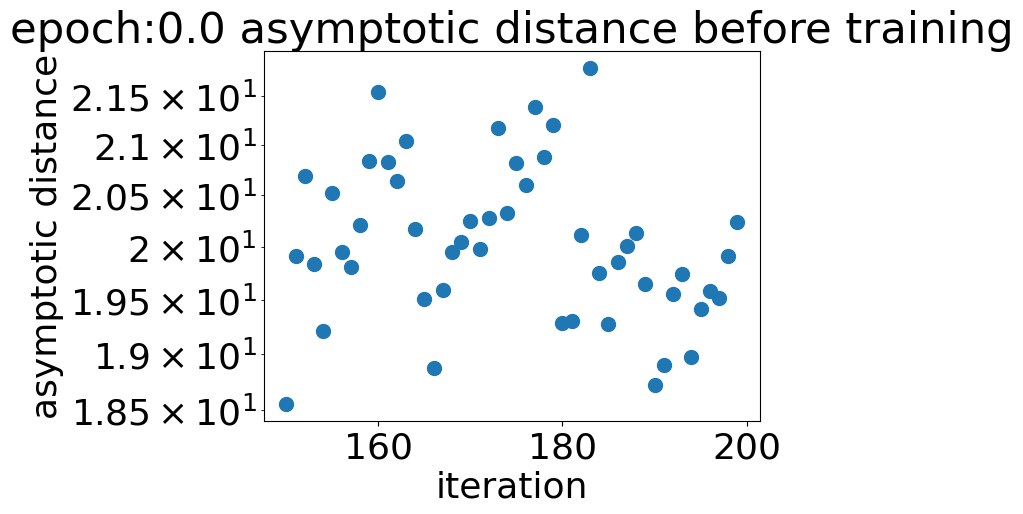

epoch : 1/100, training loss = 0.040312, validation loss = 0.026364
epoch : 2/100, training loss = 0.024093, validation loss = 0.023771
epoch : 3/100, training loss = 0.022056, validation loss = 0.021696
epoch : 4/100, training loss = 0.020879, validation loss = 0.020130
epoch : 5/100, training loss = 0.019971, validation loss = 0.020668
[0.03524027770687524, 0.009073047591454364, -5.8981660817033644e-05, 0.021962914210093623, 0.02215870574948023, 0.024419385341404285, 0.005300486572704197, 0.0027706187185206487, 0.0132743159003028, 0.032022520418081304, 0.006675225315960156, -0.021117041505731498, 0.025881489189088665, 0.024393080063789138, 0.00833564090247745, 0.007384409049649715, -0.002604311758046265, 0.031251590898989434, 0.035369666893573834, 0.02287055676279435, -0.00908651640339443, 0.006477297365034158, 0.020087509034001395, 0.005216767804352322, 0.025400664474870497, 0.0018933219574833033, 0.03281173633301172, 0.006863823538352577, 0.010822100541828885, 0.029940452355627294,

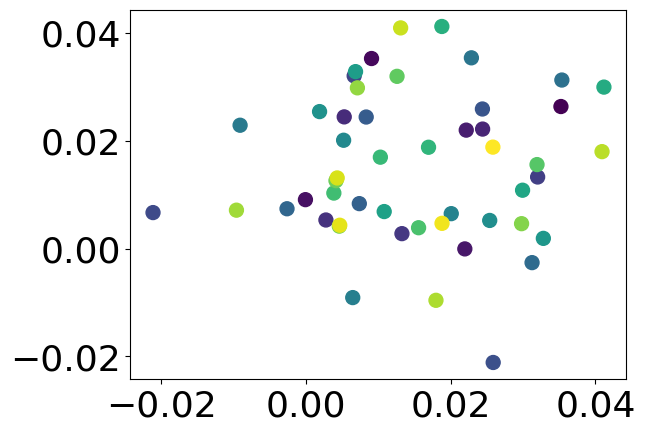

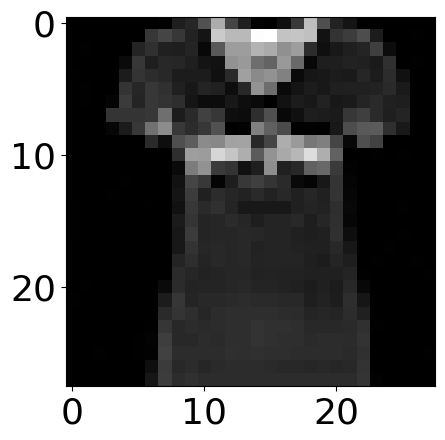

asymptotic image input epoch:5.jpg
percentage of chaos: 0.0
epoch : 6/100, training loss = 0.019216, validation loss = 0.020569
epoch : 7/100, training loss = 0.018963, validation loss = 0.020173
epoch : 8/100, training loss = 0.018381, validation loss = 0.020086
epoch : 9/100, training loss = 0.018077, validation loss = 0.018571
epoch : 10/100, training loss = 0.018186, validation loss = 0.017976
[0.3285899971252913, 0.32858996084737796, 0.32858992742301024, 0.3285898966277433, 0.328589868254784, 0.3285898421136038, 0.32858981802865933, 0.32858979583821396, 0.3285897753932519, 0.32858975655647826, 0.3285897392013966, 0.32858972321146024, 0.328589708479289, 0.3285896949059492, 0.32858968240028863, 0.32858967087832497, 0.3285896602626815, 0.32858965048206773, 0.3285896414708007, 0.3285896331683639, 0.32858962551900106, 0.32858961847134155, 0.3285896119780553, 0.3285896059955353, 0.32858960048360486, 0.32858959540524696, 0.32858959072635685, 0.3285895864155121, 0.3285895824437623, 0.3285

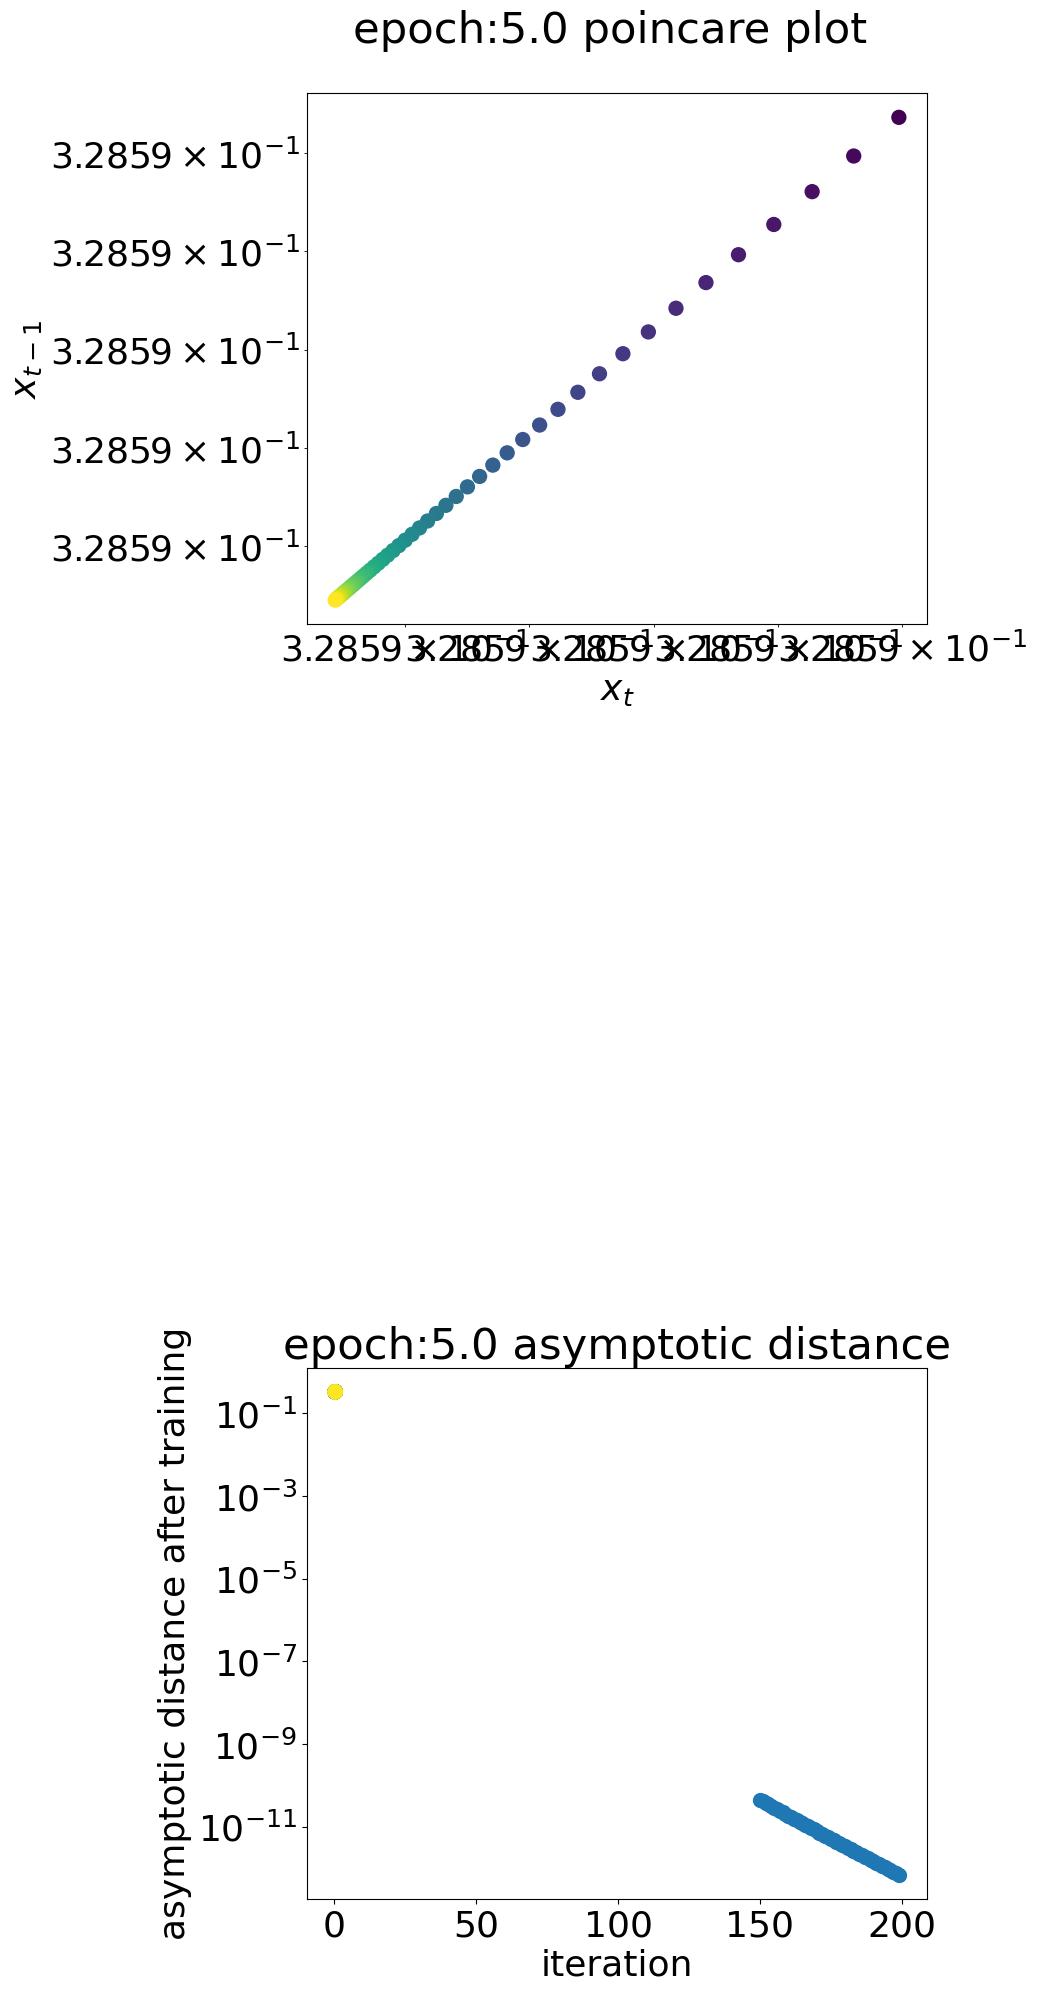

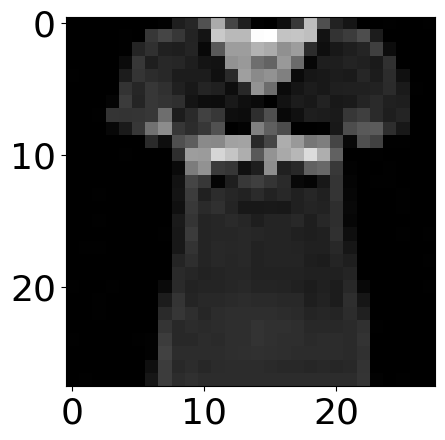

asymptotic image input epoch:10.jpg
percentage of chaos: 0.0
epoch : 11/100, training loss = 0.017656, validation loss = 0.017455
epoch : 12/100, training loss = 0.017146, validation loss = 0.017472
epoch : 13/100, training loss = 0.016918, validation loss = 0.017512
epoch : 14/100, training loss = 0.017449, validation loss = 0.017201
epoch : 15/100, training loss = 0.016761, validation loss = 0.017256
[0.6301465836316897, 0.6301483475057383, 0.6301499919156163, 0.6301515248571815, 0.6301529538041835, 0.6301542857405326, 0.6301555271908356, 0.6301566842492548, 0.6301577626067452, 0.6301587675767318, 0.6301597041192957, 0.6301605768639295, 0.6301613901309331, 0.6301621479515129, 0.6301628540866523, 0.6301635120448162, 0.6301641250985517, 0.6301646963000471, 0.6301652284957073, 0.6301657243397998, 0.6301661863072286, 0.6301666167054851, 0.6301670176858256, 0.6301673912537238, 0.6301677392786396, 0.6301680635031494, 0.6301683655514756, 0.6301686469374552, 0.6301689090719798, 0.63016915326

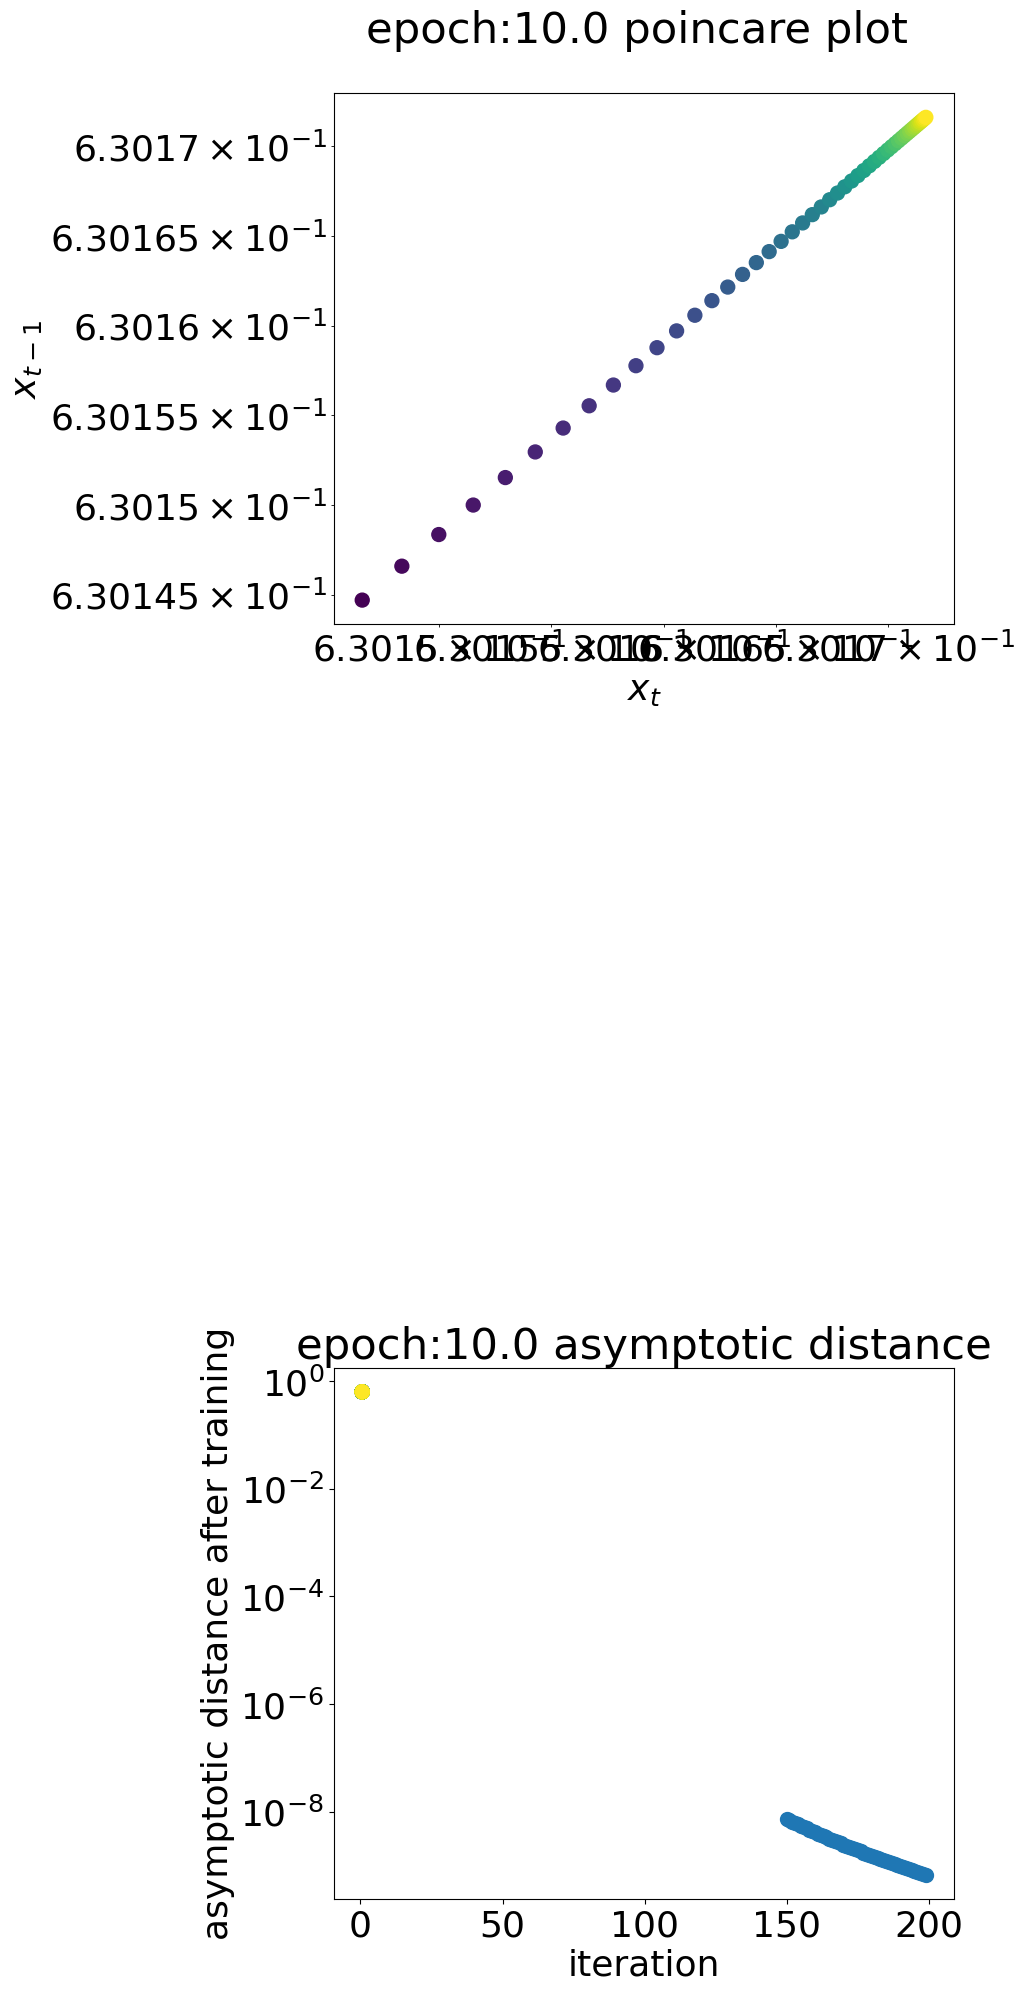

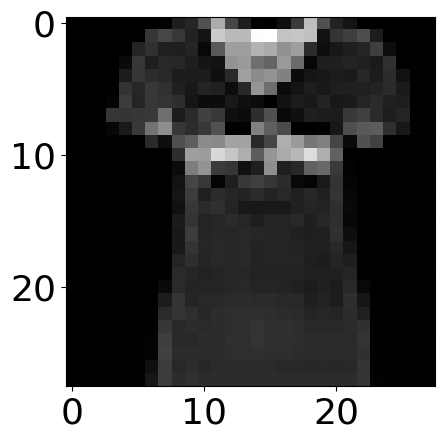

asymptotic image input epoch:15.jpg
percentage of chaos: 0.1
epoch : 16/100, training loss = 0.016443, validation loss = 0.016831
epoch : 17/100, training loss = 0.016454, validation loss = 0.017913
epoch : 18/100, training loss = 0.017079, validation loss = 0.018648
epoch : 19/100, training loss = 0.016421, validation loss = 0.017131
epoch : 20/100, training loss = 0.016015, validation loss = 0.016299
[0.5981754287625739, 0.5981124531546207, 0.5980548347686588, 0.5980020643733925, 0.5979536887186202, 0.5979093041798224, 0.5978685508474754, 0.5978311071586592, 0.5977966851083878, 0.5977650260367868, 0.5977358969616786, 0.5977090874106565, 0.597684406699292, 0.5976616816002179, 0.597640754349587, 0.5976214809413319, 0.5976037296647574, 0.5975873798465052, 0.5975723207634299, 0.5975584506980478, 0.59754567611288, 0.5975339109240806, 0.597523075858243, 0.5975130978792271, 0.5975039096743054, 0.5974954491909368, 0.5974876592171103, 0.5974804869995217, 0.5974738838948919, 0.5974678050505806

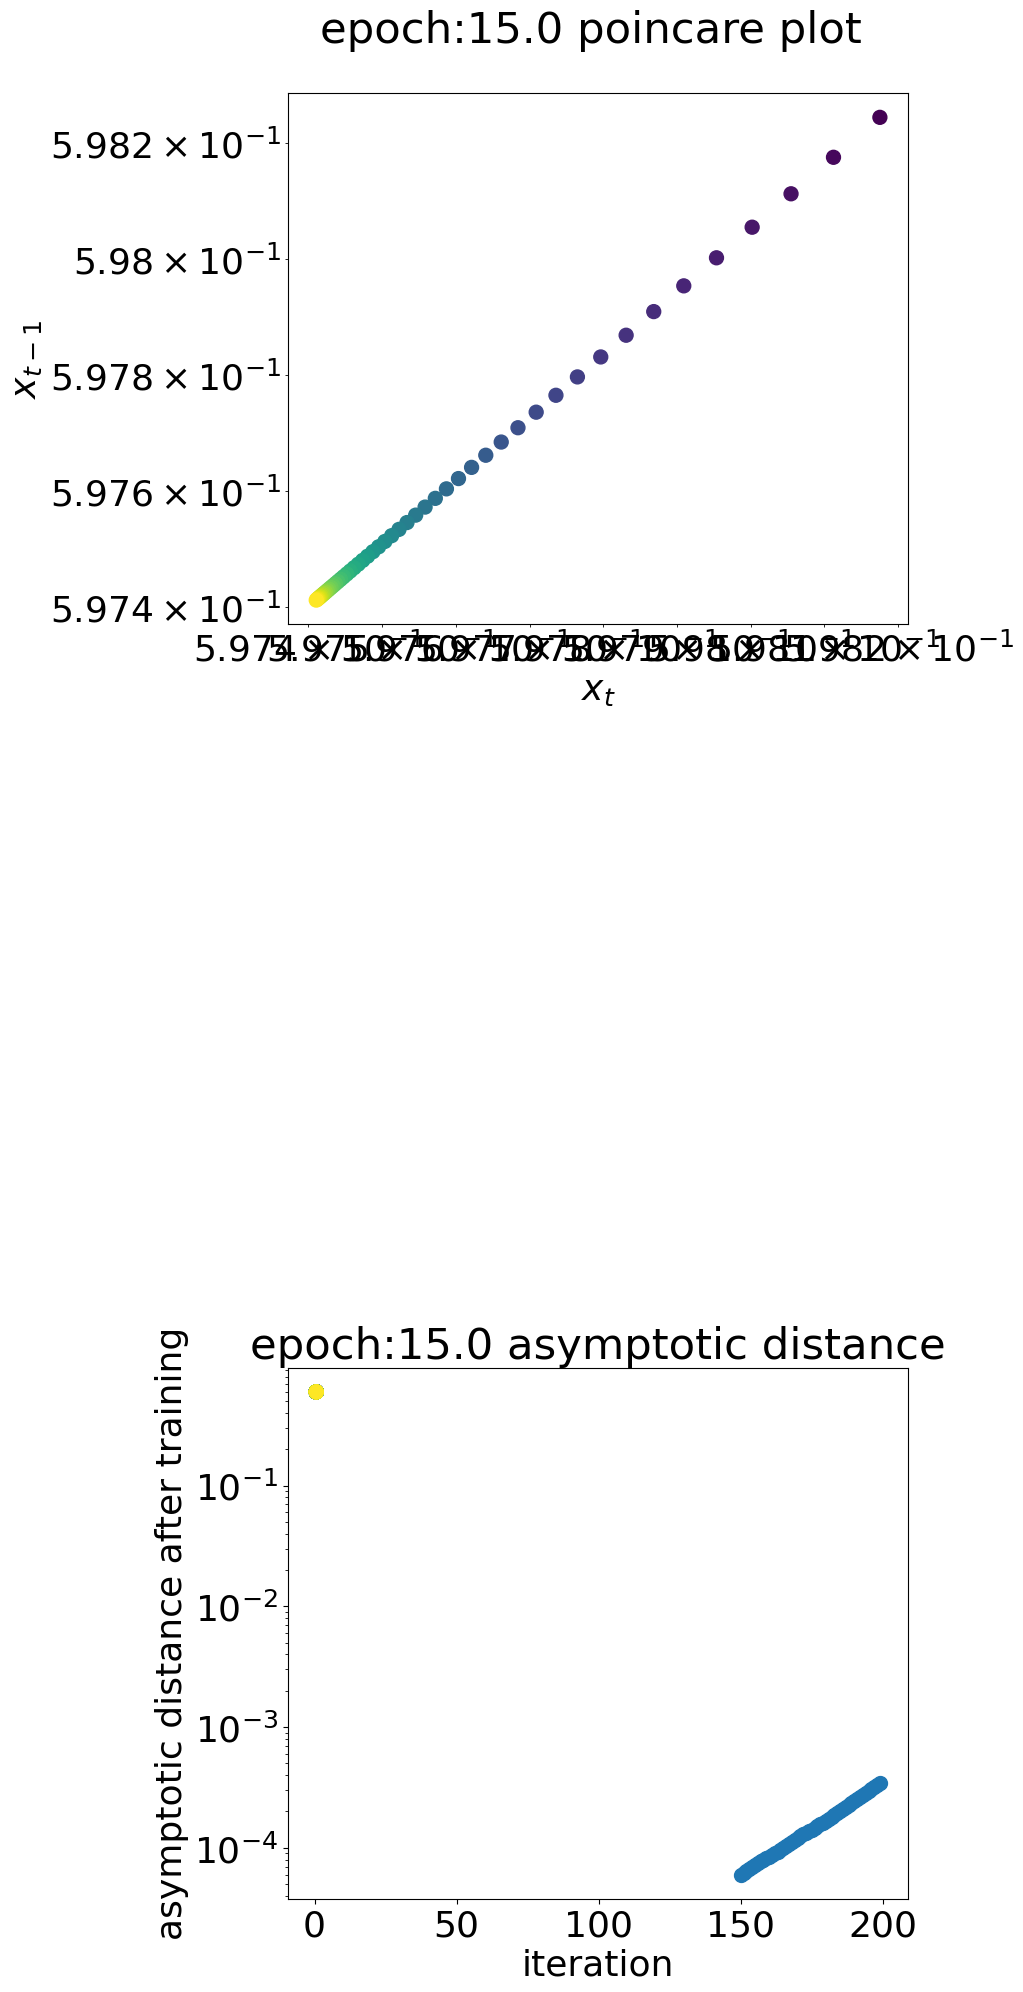

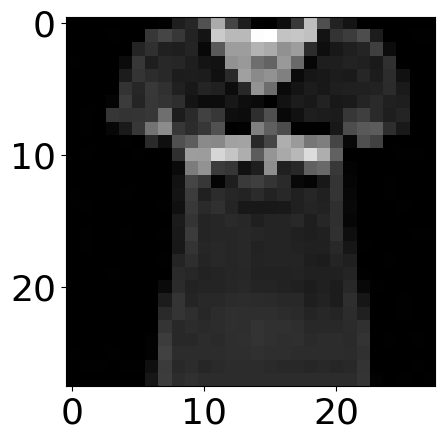

asymptotic image input epoch:20.jpg
percentage of chaos: 0.0
epoch : 21/100, training loss = 0.015727, validation loss = 0.016156
epoch : 22/100, training loss = 0.016170, validation loss = 0.017231
epoch : 23/100, training loss = 0.016449, validation loss = 0.016767
epoch : 24/100, training loss = 0.015982, validation loss = 0.016416
epoch : 25/100, training loss = 0.015484, validation loss = 0.015925
[0.5135419389268937, 0.5135419146630348, 0.5135418927292699, 0.5135418729105488, 0.5135418550123176, 0.5135418388580181, 0.5135418242870354, 0.5135418111529988, 0.5135417993223585, 0.5135417886731795, 0.5135417790941048, 0.5135417704834505, 0.5135417627484082, 0.5135417558043277, 0.5135417495740688, 0.5135417439874087, 0.5135417389804948, 0.5135417344953381, 0.5135417304793417, 0.5135417268848608, 0.5135417236687926, 0.5135417207921927, 0.5135417182199178, 0.5135417159202925, 0.5135417138647999, 0.5135417120277948, 0.5135417103862373, 0.5135417089194491, 0.513541707608886, 0.513541706437

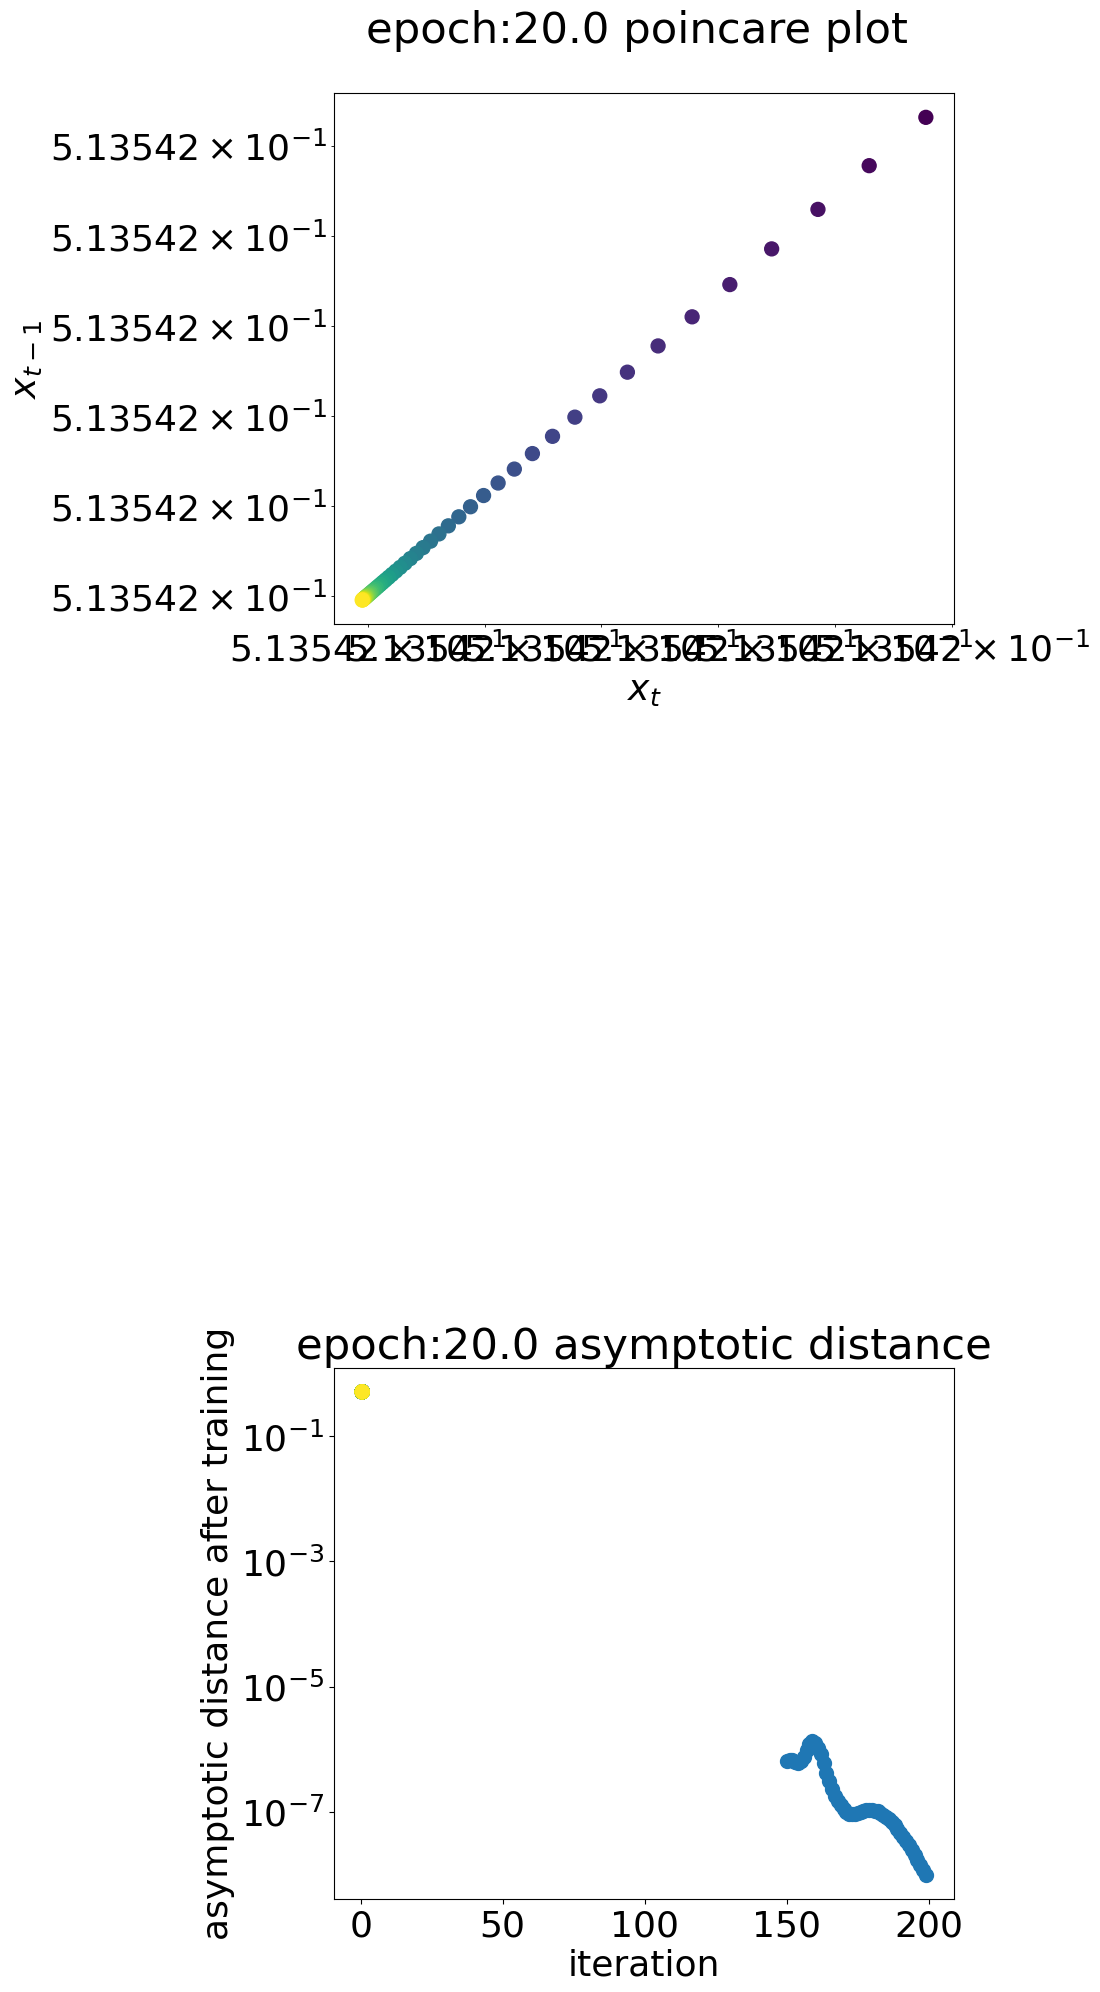

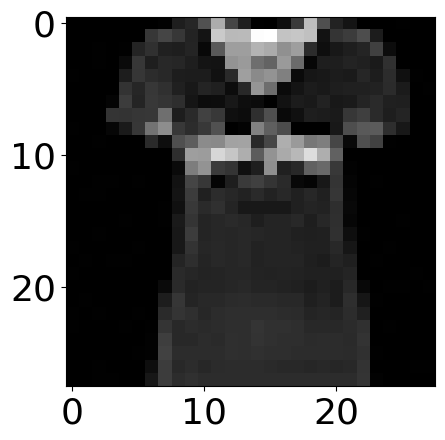

asymptotic image input epoch:25.jpg
percentage of chaos: 0.0
epoch : 26/100, training loss = 0.015206, validation loss = 0.015891
epoch : 27/100, training loss = 0.015412, validation loss = 0.016175
epoch : 28/100, training loss = 0.015676, validation loss = 0.017688
epoch : 29/100, training loss = 0.015891, validation loss = 0.016799
epoch : 30/100, training loss = 0.015679, validation loss = 0.016193
[0.5211113269128896, 0.5211113305993044, 0.521111333943193, 0.5211113369763815, 0.5211113397277388, 0.5211113422234515, 0.5211113444872728, 0.5211113465407495, 0.5211113484034258, 0.5211113500930298, 0.5211113516256428, 0.521111353015852, 0.5211113542768885, 0.521111355420755, 0.5211113564583381, 0.5211113573995132, 0.5211113582532383, 0.5211113590276388, 0.5211113597300852, 0.5211113603672631, 0.5211113609452374, 0.5211113614695084, 0.5211113619450665, 0.5211113623764376, 0.5211113627677276, 0.5211113631226605, 0.5211113634446145, 0.5211113637366539, 0.5211113640015581, 0.52111136424184

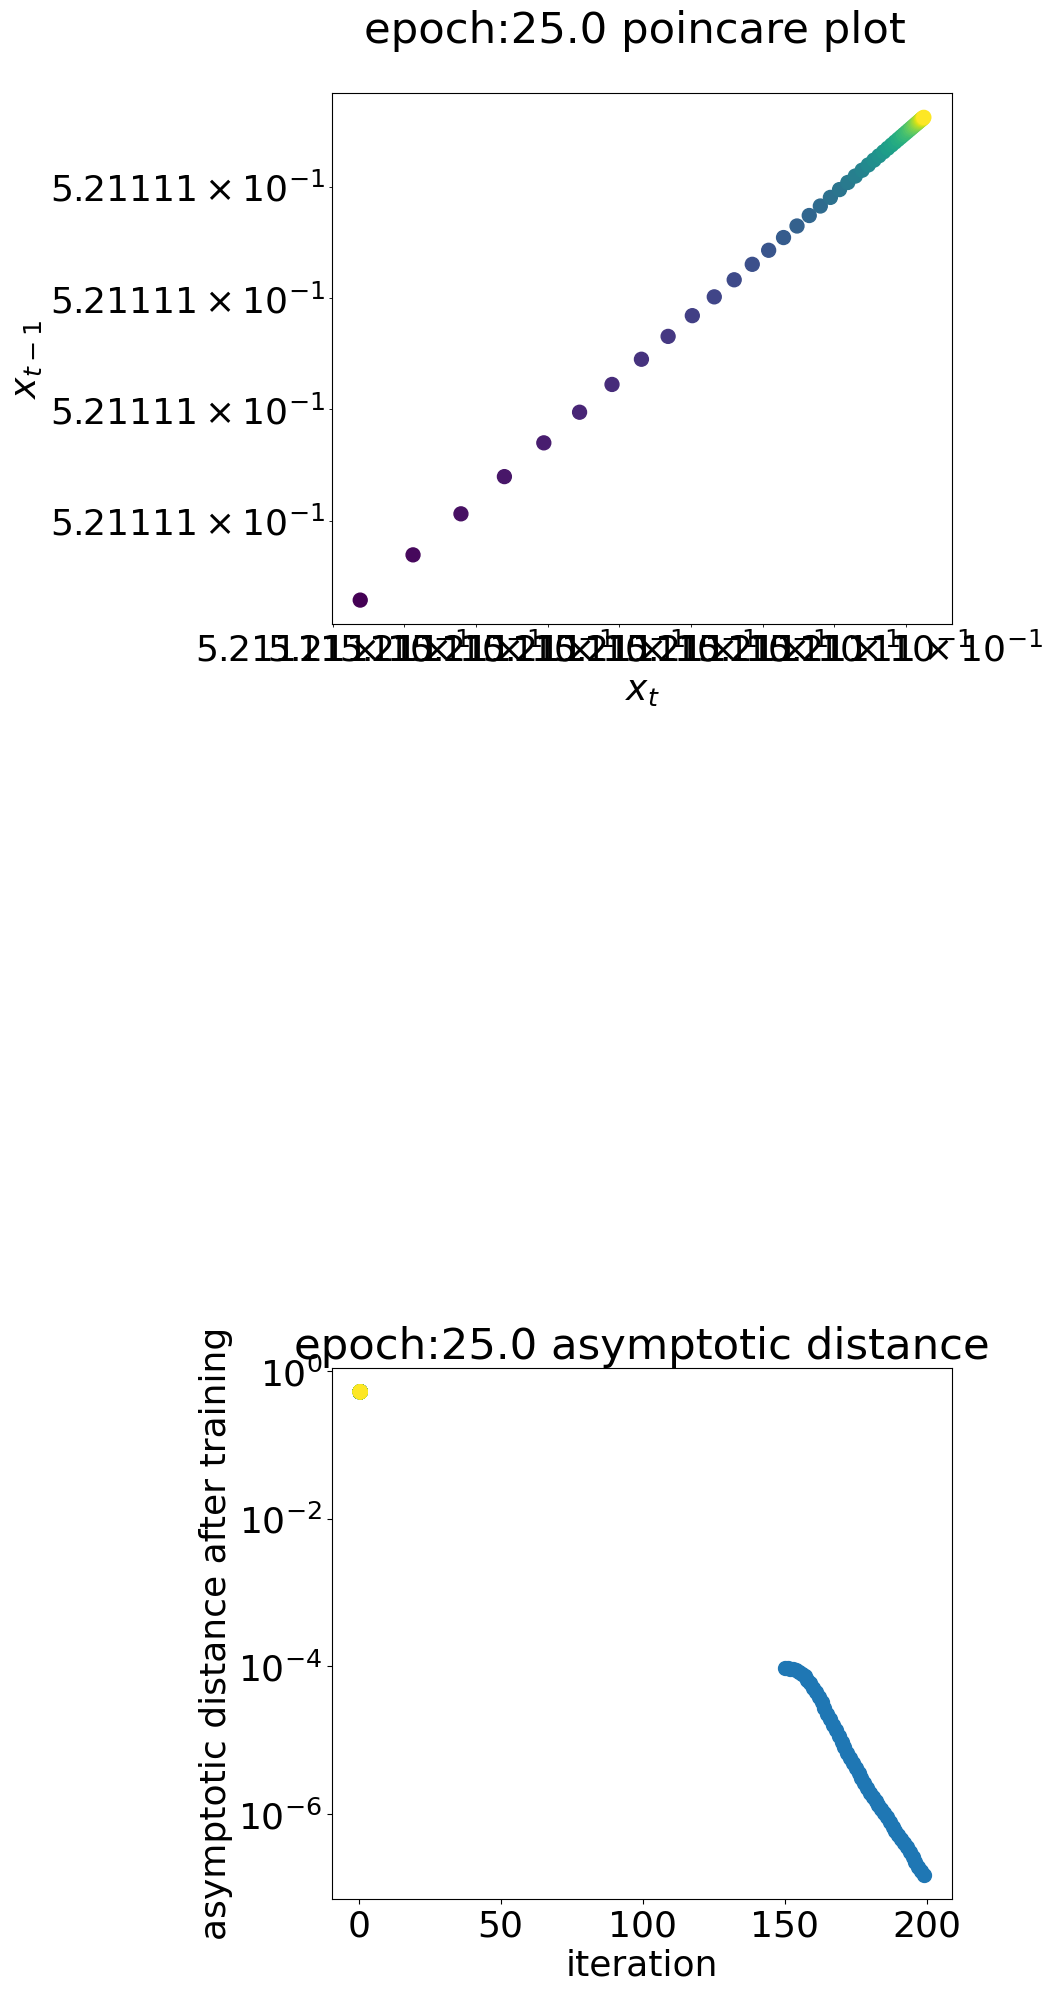

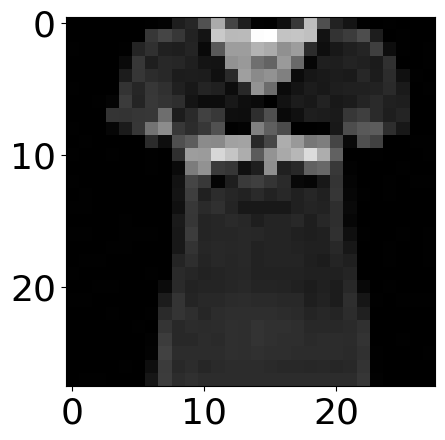

asymptotic image input epoch:30.jpg
percentage of chaos: 0.0
epoch : 31/100, training loss = 0.015305, validation loss = 0.015853
epoch : 32/100, training loss = 0.014927, validation loss = 0.015845
epoch : 33/100, training loss = 0.014821, validation loss = 0.016104
epoch : 34/100, training loss = 0.015434, validation loss = 0.016450
epoch : 35/100, training loss = 0.015559, validation loss = 0.016576
[0.6396441183729343, 0.6396149243233322, 0.6395864370287252, 0.639558629896537, 0.6395314776981714, 0.6395049564804721, 0.6394790434841134, 0.6394537170682908, 0.6394289566411441, 0.6394047425954075, 0.6393810562488276, 0.6393578797889363, 0.6393351962218083, 0.6393129893244675, 0.6392912436006356, 0.6392699442395537, 0.6392490770776218, 0.6392286285626329, 0.639208585720398, 0.6391889361235708, 0.6391696678625061, 0.6391507695179935, 0.6391322301357281, 0.639114039202385, 0.6390961866231822, 0.6390786627008245, 0.6390614581157228, 0.6390445639074072, 0.6390279714570407, 0.63901167247096

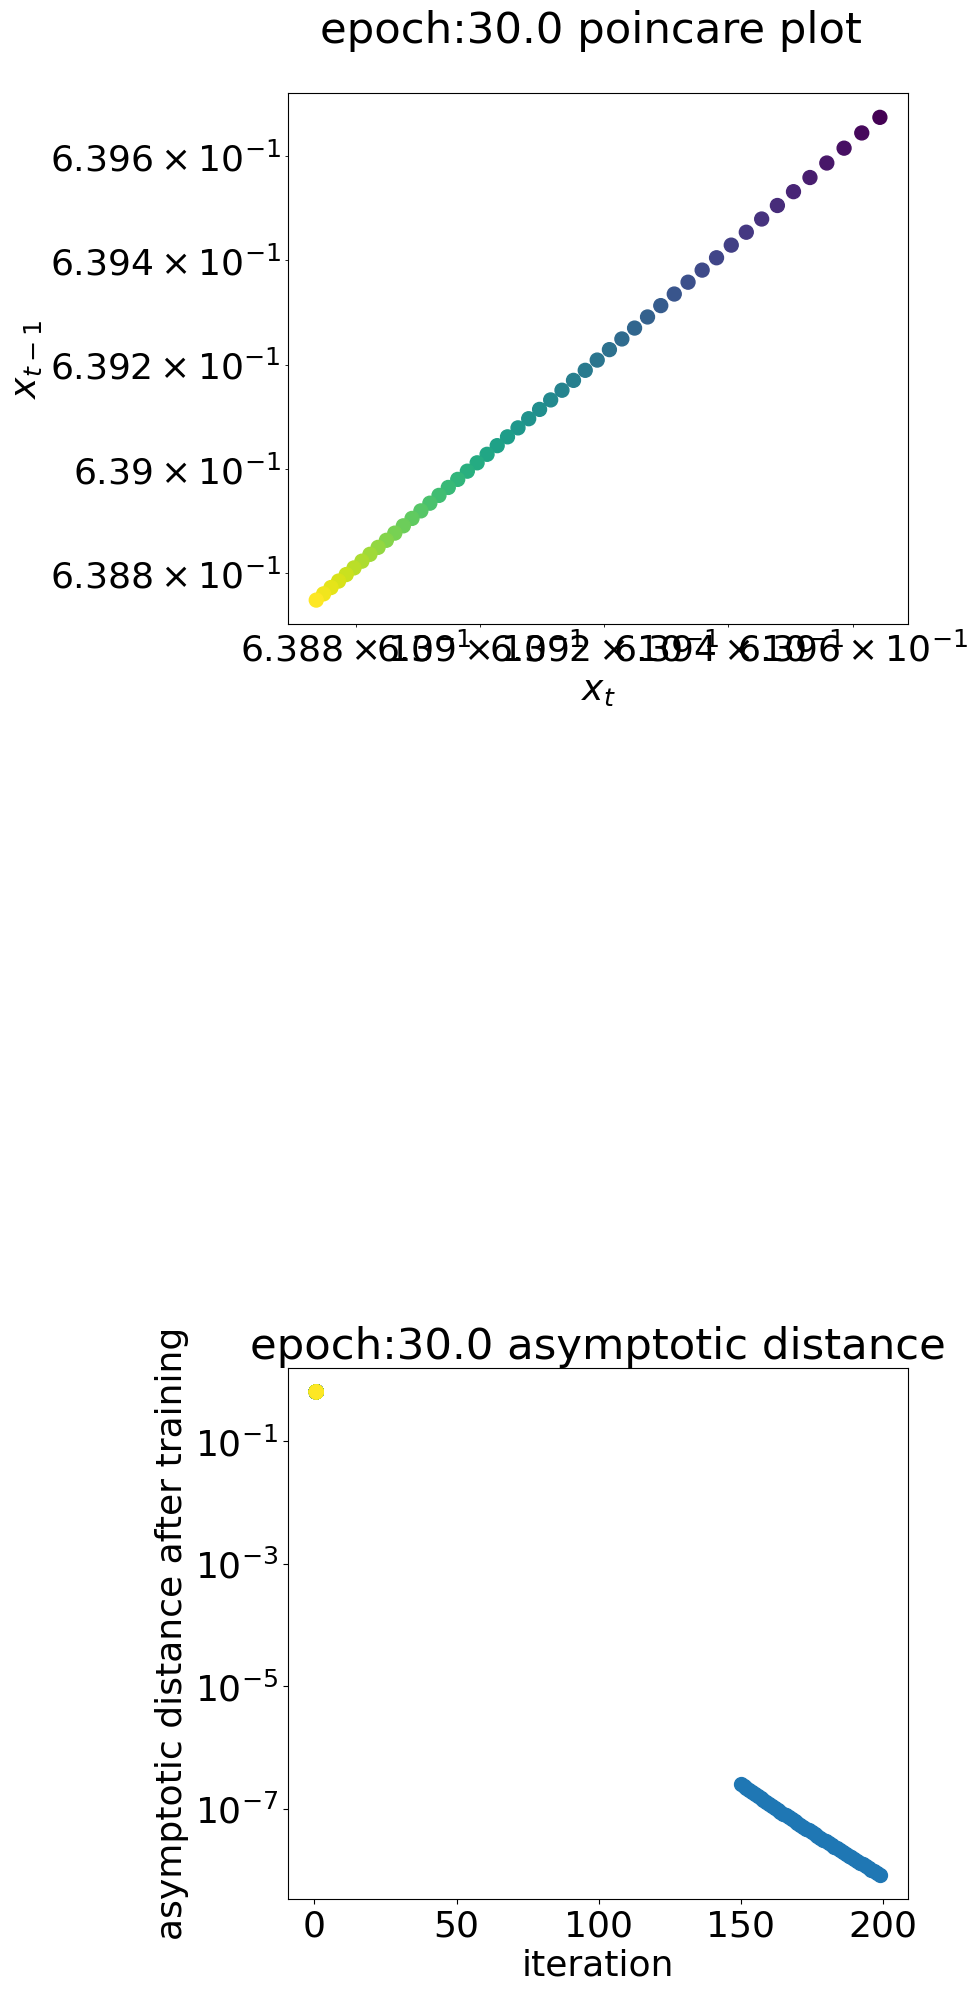

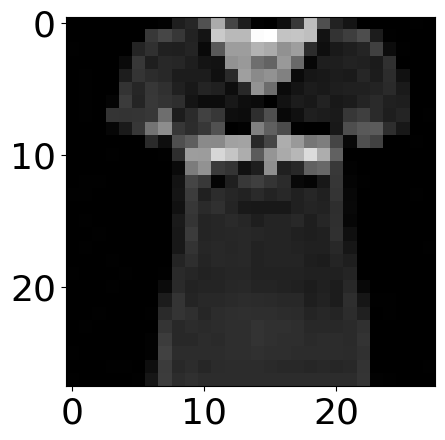

asymptotic image input epoch:35.jpg
percentage of chaos: 0.0
epoch : 36/100, training loss = 0.015601, validation loss = 0.015673
epoch : 37/100, training loss = 0.015230, validation loss = 0.015620
epoch : 38/100, training loss = 0.014746, validation loss = 0.015481
epoch : 39/100, training loss = 0.014490, validation loss = 0.015494
epoch : 40/100, training loss = 0.014453, validation loss = 0.015710
[0.7393969853493593, 0.7393969853493512, 0.7393969853493456, 0.7393969853493422, 0.7393969853493398, 0.7393969853493385, 0.7393969853493376, 0.7393969853493373, 0.7393969853493372, 0.7393969853493371, 0.7393969853493371, 0.7393969853493372, 0.7393969853493372, 0.7393969853493373, 0.7393969853493373, 0.7393969853493373, 0.7393969853493375, 0.7393969853493376, 0.7393969853493376, 0.7393969853493376, 0.7393969853493376, 0.7393969853493376, 0.7393969853493376, 0.7393969853493376, 0.7393969853493376, 0.7393969853493377, 0.7393969853493377, 0.7393969853493377, 0.7393969853493377, 0.73939698534

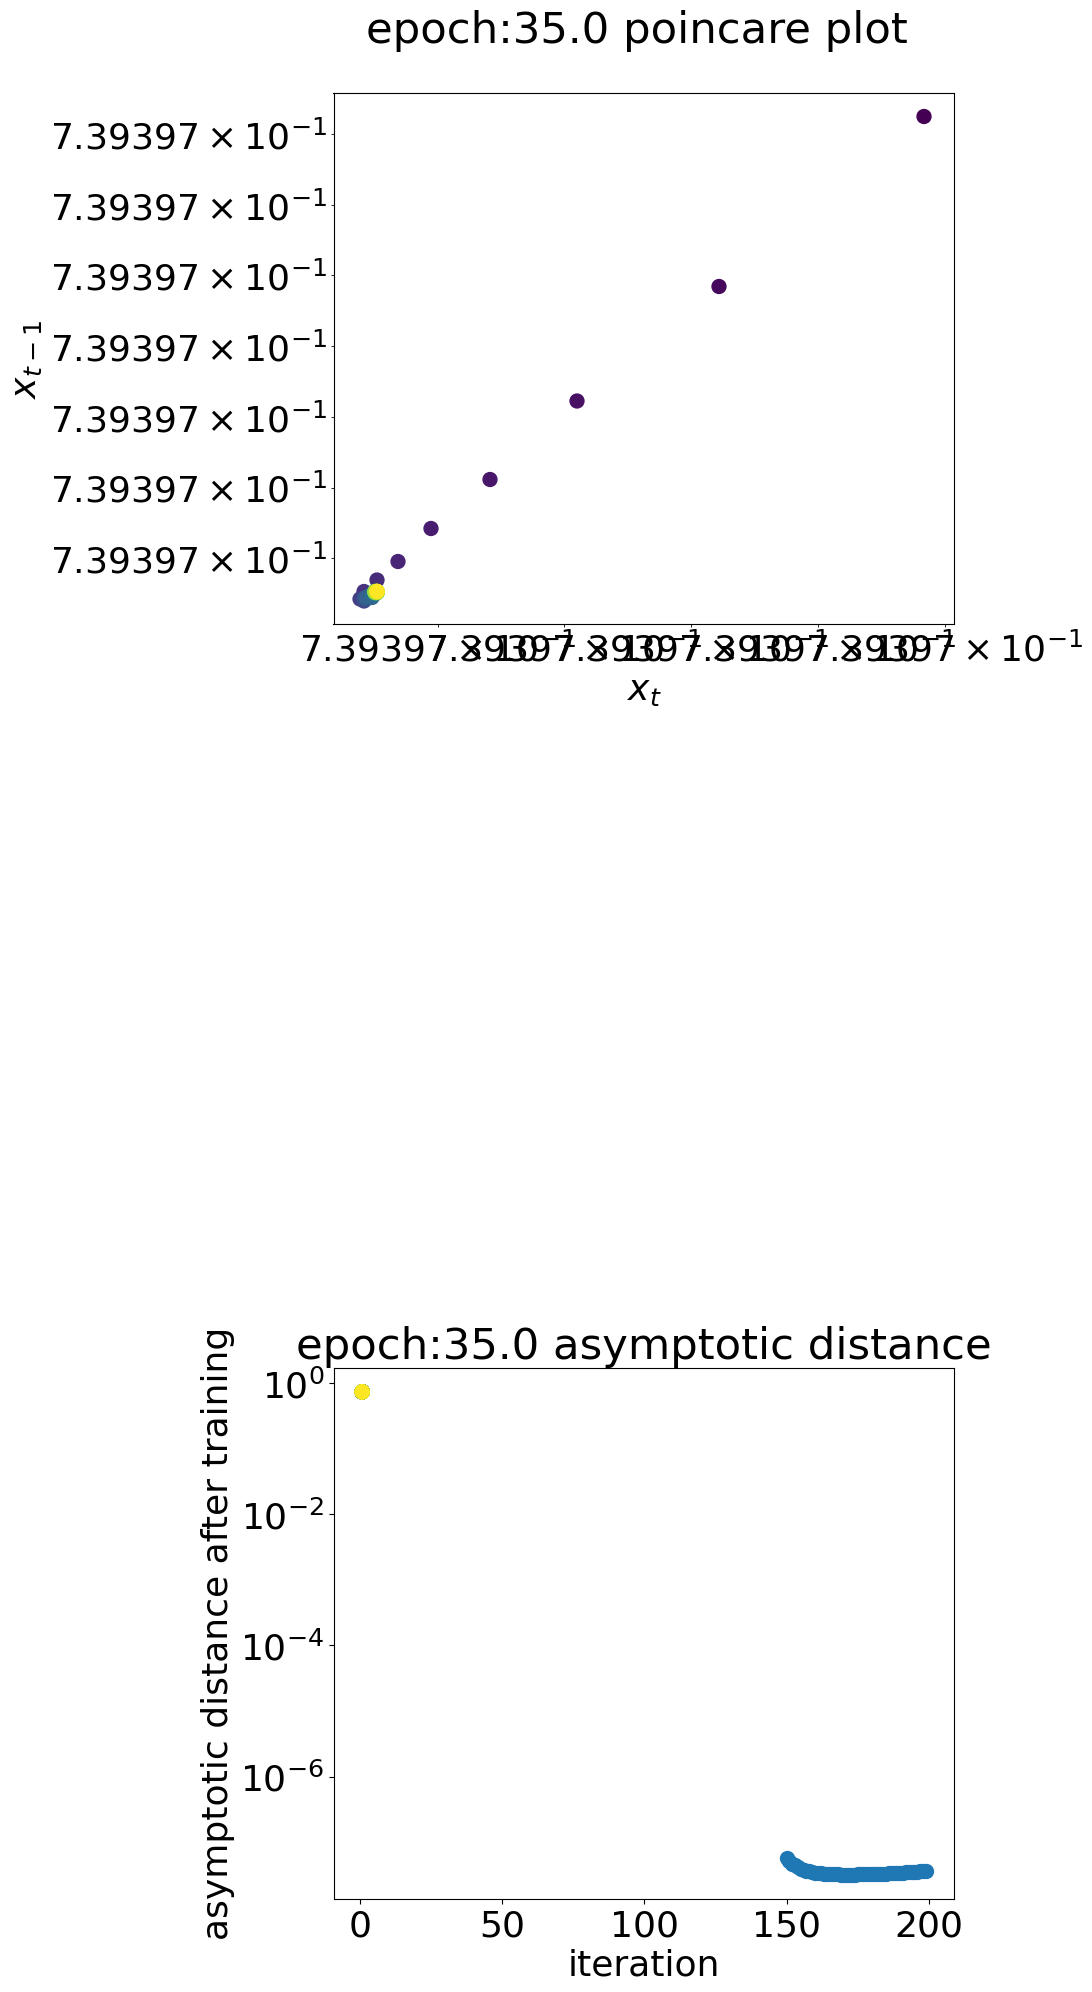

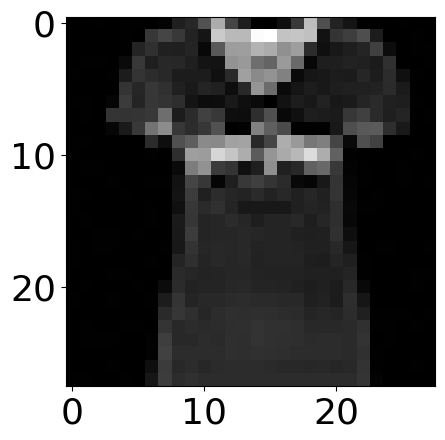

asymptotic image input epoch:40.jpg
percentage of chaos: 0.05
epoch : 41/100, training loss = 0.014876, validation loss = 0.015893
epoch : 42/100, training loss = 0.015021, validation loss = 0.015557
epoch : 43/100, training loss = 0.015214, validation loss = 0.016015
epoch : 44/100, training loss = 0.015261, validation loss = 0.016422
epoch : 45/100, training loss = 0.015091, validation loss = 0.016618
[0.34889327180241253, 0.3492310222948521, 0.34946411079112794, 0.3495635637332305, 0.3494917168890577, 0.34919786787840335, 0.34861158175052526, 0.34763427825575544, 0.3461342805043746, 0.3439629931670334, 0.3410302390414049, 0.33745861224313056, 0.33367469272195466, 0.3301948992774414, 0.32729818497059365, 0.32498437395621066, 0.3231606319637145, 0.32183803795235083, 0.32114753462598367, 0.32114545235939396, 0.3217345453389743, 0.3227875505286357, 0.324222017914099, 0.3259744376616534, 0.3279638462627016, 0.3300592622517009, 0.33207973649689376, 0.3338716529401691, 0.33537104251996463,

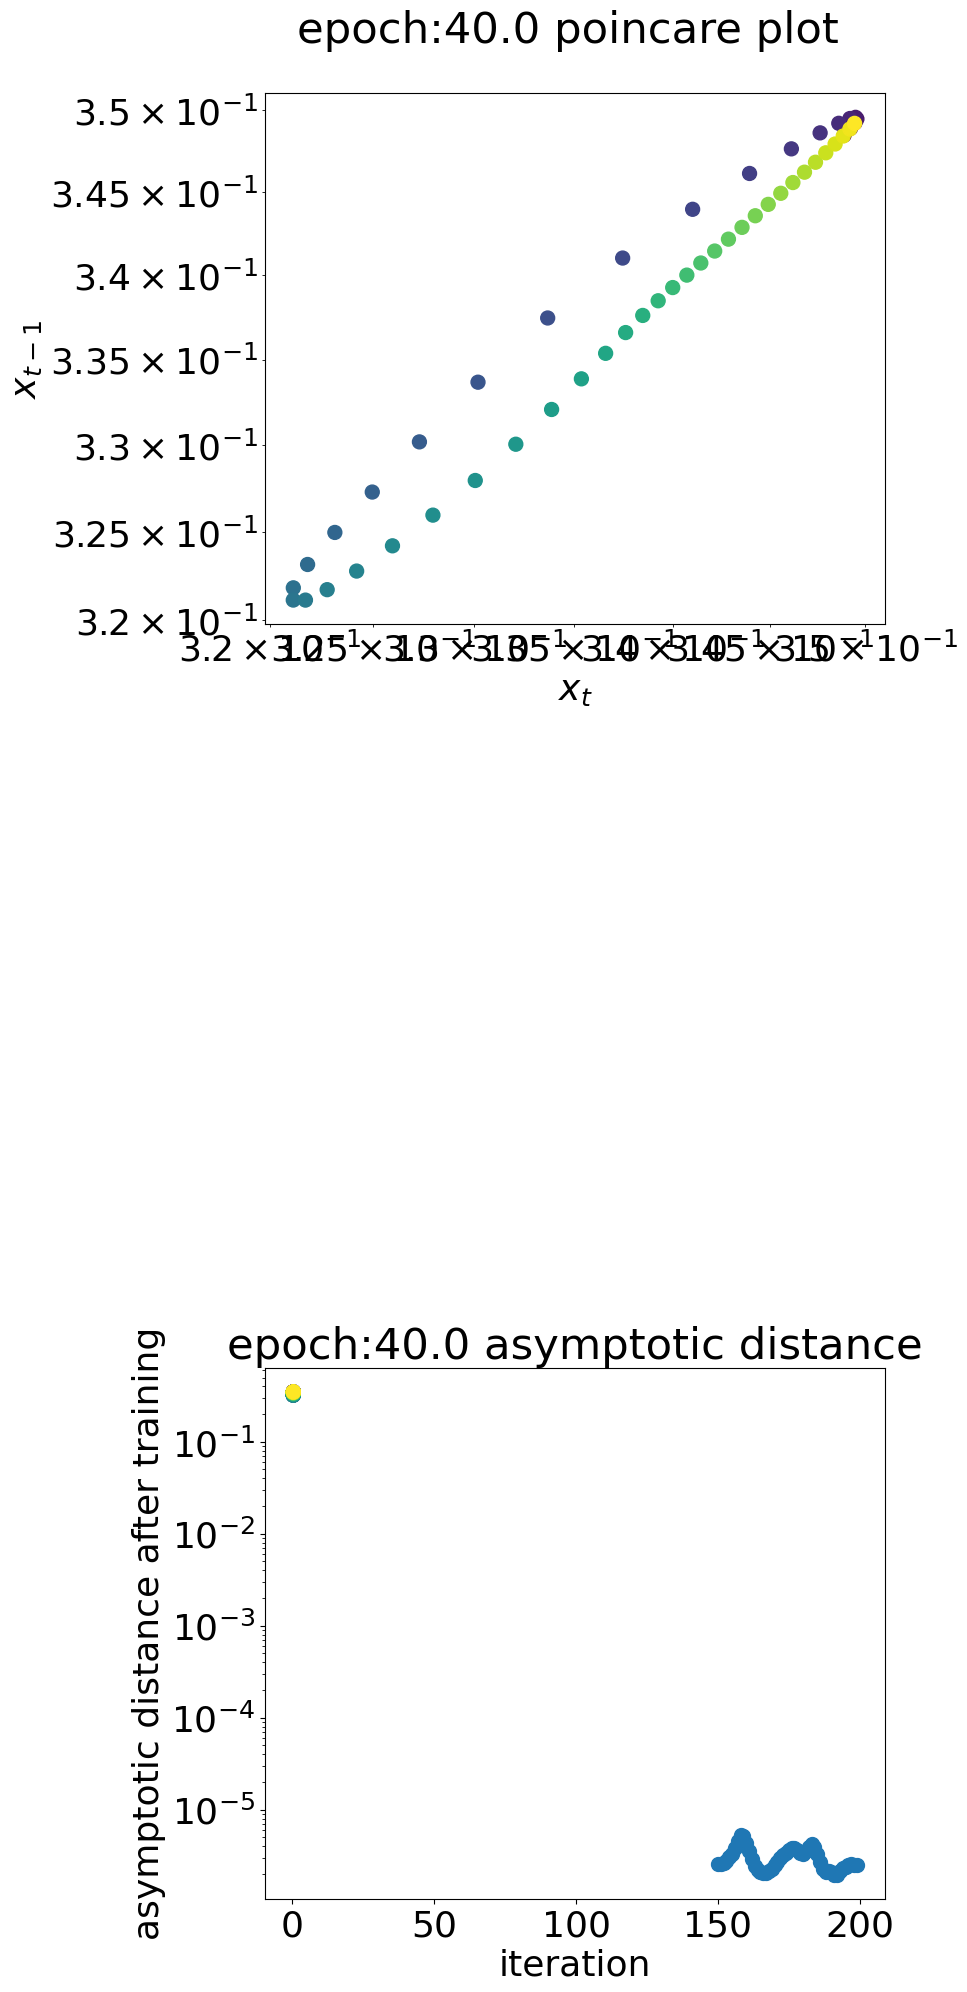

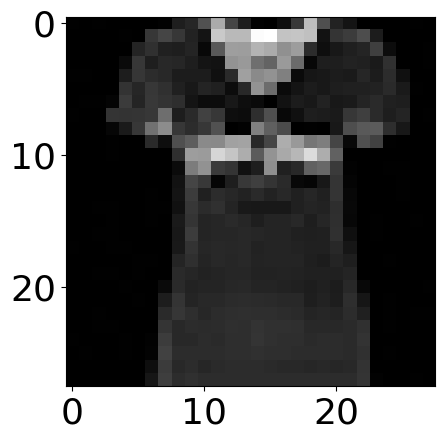

asymptotic image input epoch:45.jpg
percentage of chaos: 0.0
epoch : 46/100, training loss = 0.014845, validation loss = 0.016365
epoch : 47/100, training loss = 0.014447, validation loss = 0.015637
epoch : 48/100, training loss = 0.014127, validation loss = 0.015261
epoch : 49/100, training loss = 0.014125, validation loss = 0.015499
epoch : 50/100, training loss = 0.014471, validation loss = 0.015856
[0.08264664367877138, 0.08264664367877143, 0.08264664367877145, 0.08264664367877143, 0.08264664367877145, 0.08264664367877143, 0.08264664367877143, 0.08264664367877145, 0.08264664367877145, 0.08264664367877145, 0.08264664367877145, 0.08264664367877149, 0.08264664367877149, 0.08264664367877149, 0.0826466436787715, 0.0826466436787715, 0.0826466436787715, 0.08264664367877153, 0.08264664367877153, 0.08264664367877149, 0.08264664367877149, 0.08264664367877153, 0.0826466436787715, 0.08264664367877148, 0.08264664367877148, 0.08264664367877149, 0.08264664367877148, 0.08264664367877149, 0.0826466

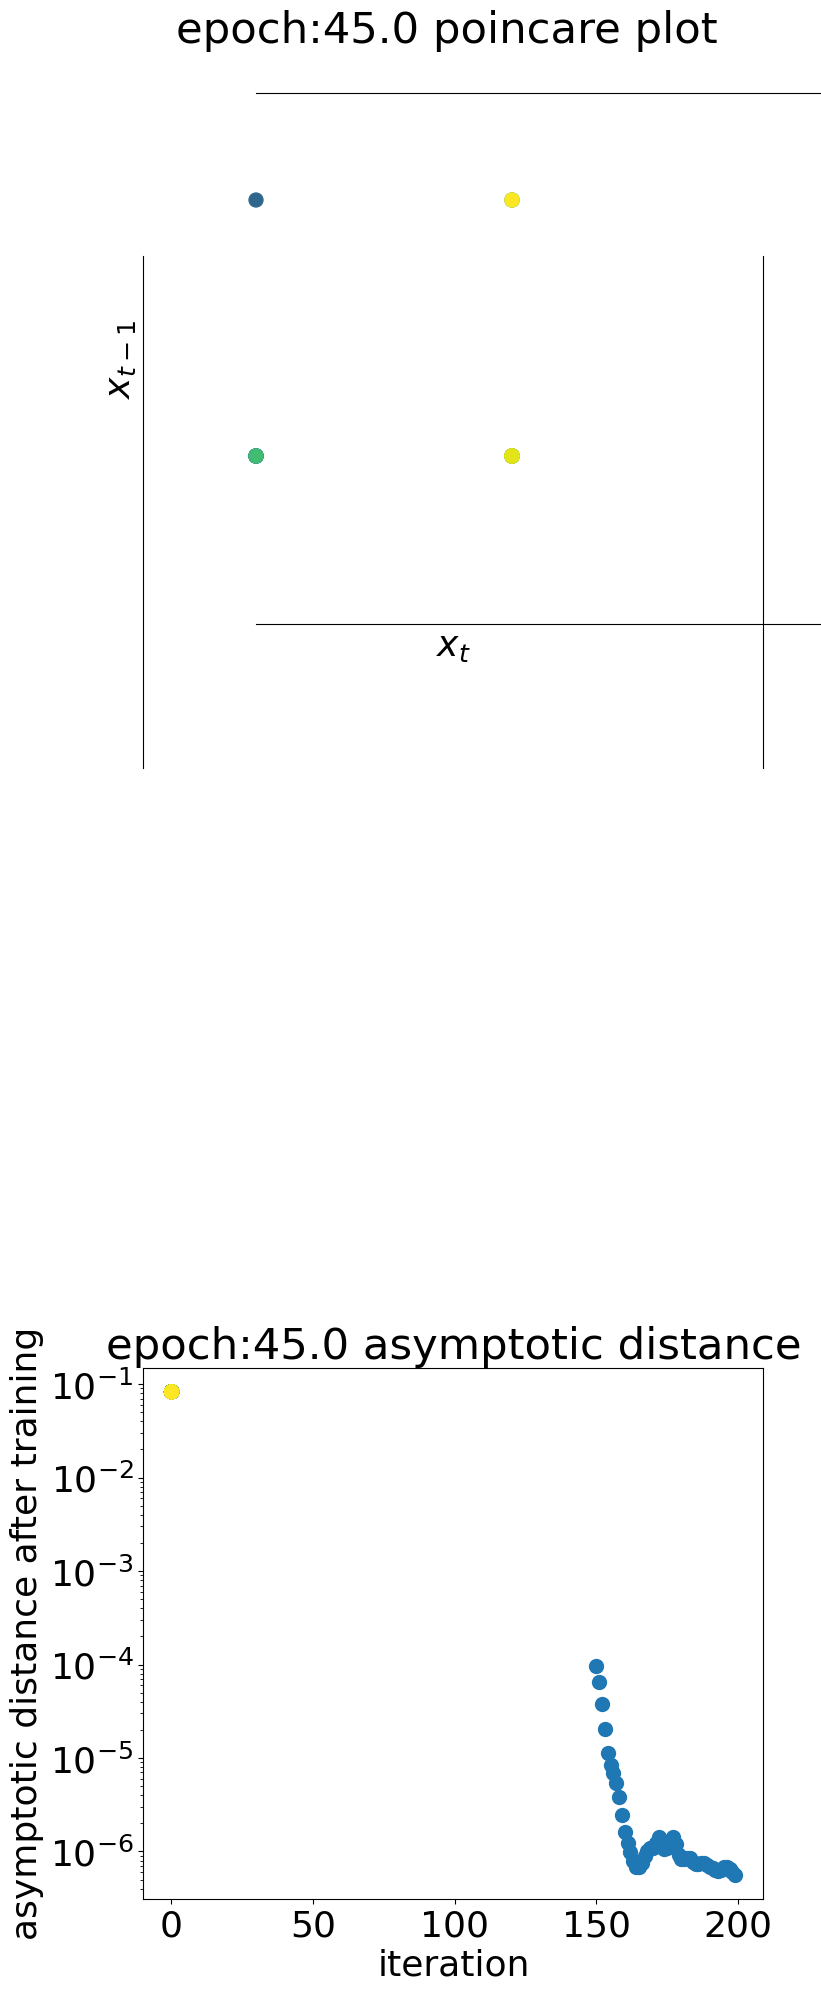

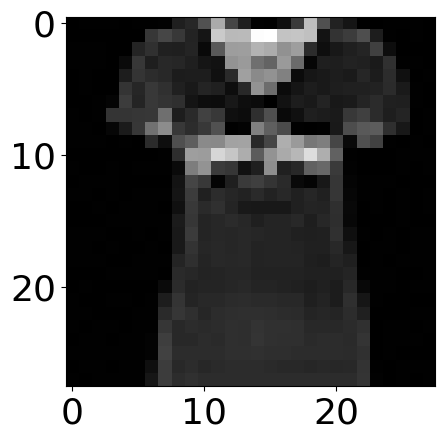

asymptotic image input epoch:50.jpg
percentage of chaos: 0.0
epoch : 51/100, training loss = 0.014766, validation loss = 0.015640
epoch : 52/100, training loss = 0.014873, validation loss = 0.016720
epoch : 53/100, training loss = 0.015142, validation loss = 0.016177
epoch : 54/100, training loss = 0.015072, validation loss = 0.016134
epoch : 55/100, training loss = 0.014705, validation loss = 0.015923
[0.41736741641843256, 0.41912551650960944, 0.41993845686334347, 0.42019310688617717, 0.4201533987701974, 0.41996406408361003, 0.41969494797814927, 0.4193753208015054, 0.4190141493661153, 0.41861093393679577, 0.4181610568755532, 0.41765803247174355, 0.41709393768194625, 0.4164585890605376, 0.41573759248871045, 0.4149092188329536, 0.41394015933990247, 0.41278024641016725, 0.41135558697559527, 0.4095602274570495, 0.4072559607238658, 0.4043105569660022, 0.4006989528960411, 0.39659715521394895, 0.3923440343172043, 0.38828552935485766, 0.38464195829283965, 0.3815012968014825, 0.378886294297883

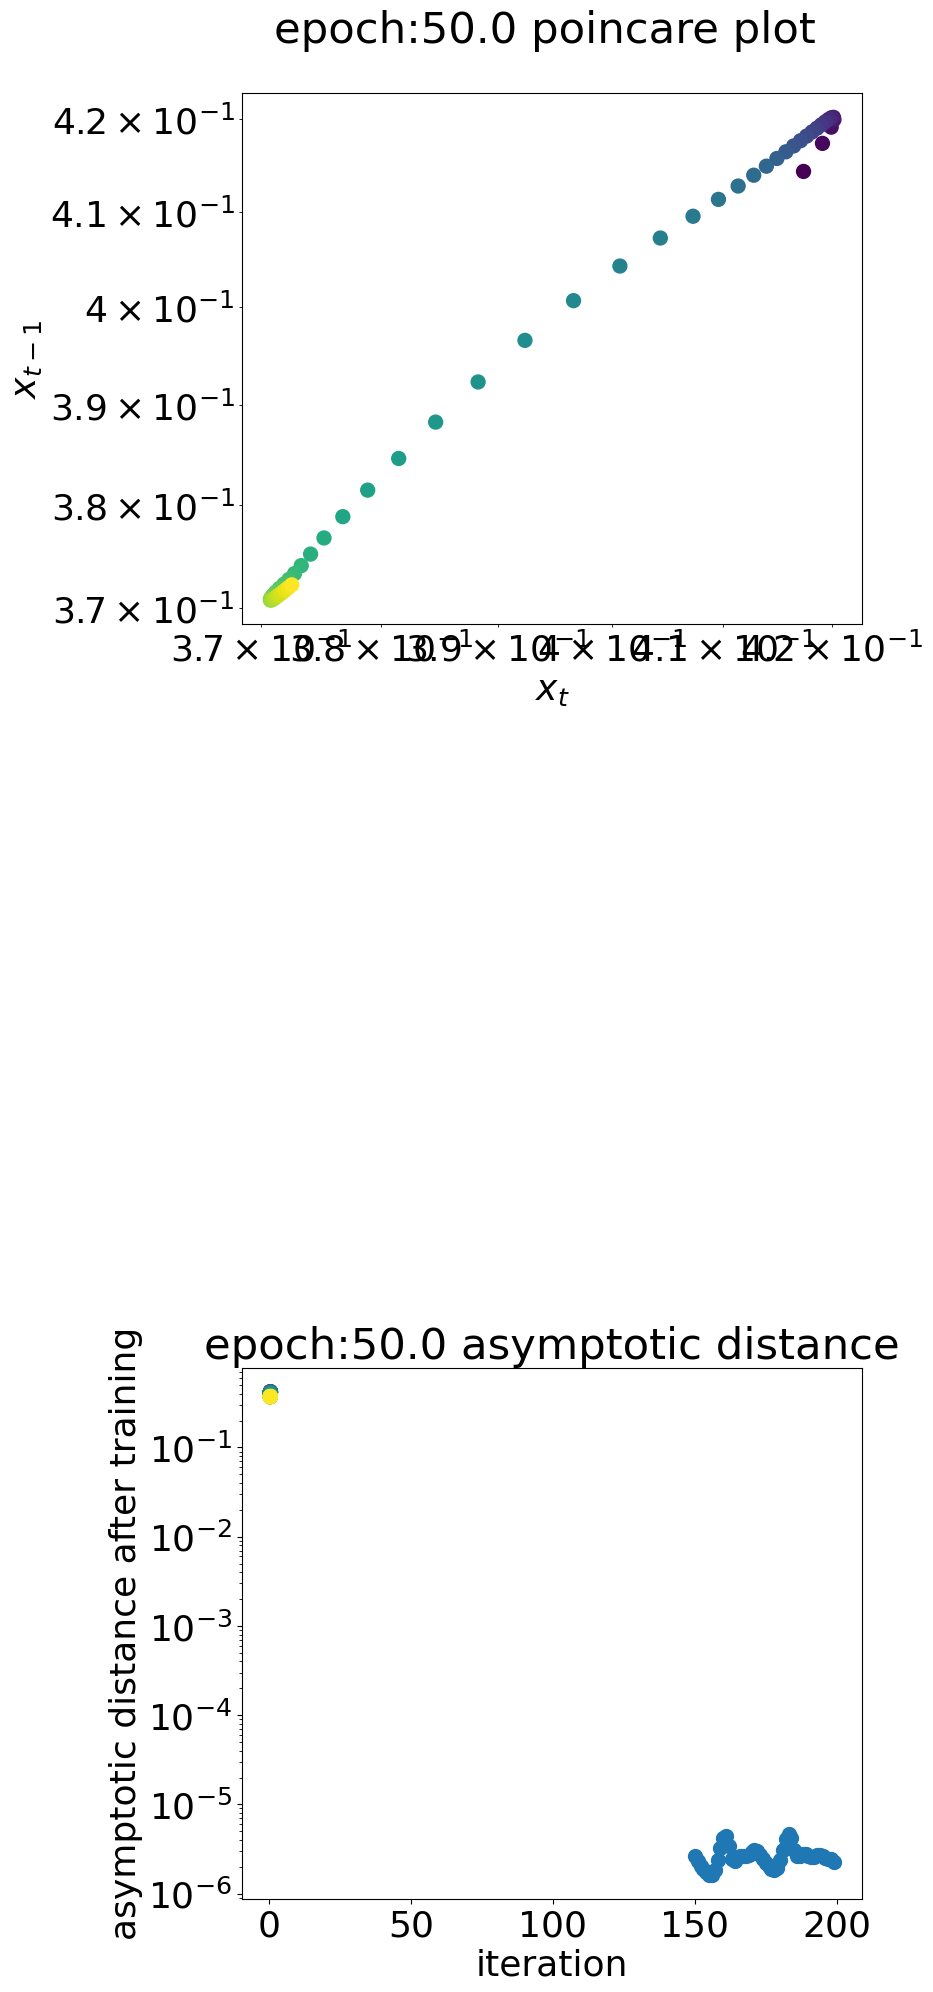

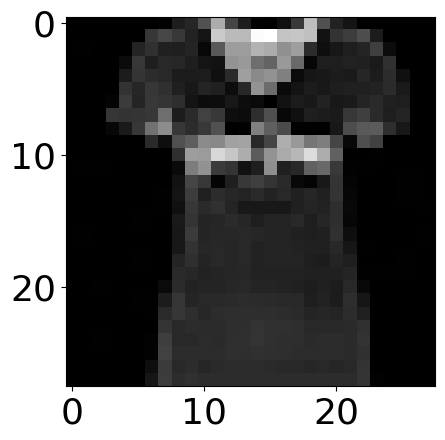

asymptotic image input epoch:55.jpg
percentage of chaos: 0.0
epoch : 56/100, training loss = 0.014225, validation loss = 0.015565
epoch : 57/100, training loss = 0.013894, validation loss = 0.015504
epoch : 58/100, training loss = 0.013903, validation loss = 0.015471
epoch : 59/100, training loss = 0.014269, validation loss = 0.015732
epoch : 60/100, training loss = 0.014345, validation loss = 0.015943
[0.4219791870421083, 0.4219843553458133, 0.4219923724376418, 0.4220026418981474, 0.42201450133394397, 0.42202725499181815, 0.4220402061954397, 0.4220526890237834, 0.4220640983603335, 0.4220739170897859, 0.42208173893408374, 0.42208728533021916, 0.42209041494446453, 0.4220911249055306, 0.4220895435561963, 0.4220859153400862, 0.42208057920295816, 0.4220739424591934, 0.42206645236868007, 0.4220585676677088, 0.4220507320407924, 0.4220433510889167, 0.42203677383740434, 0.42203127931792966, 0.4220270683156566, 0.42202426002777765, 0.42202289314284946, 0.4220229307120802, 0.422024268124314, 0.4

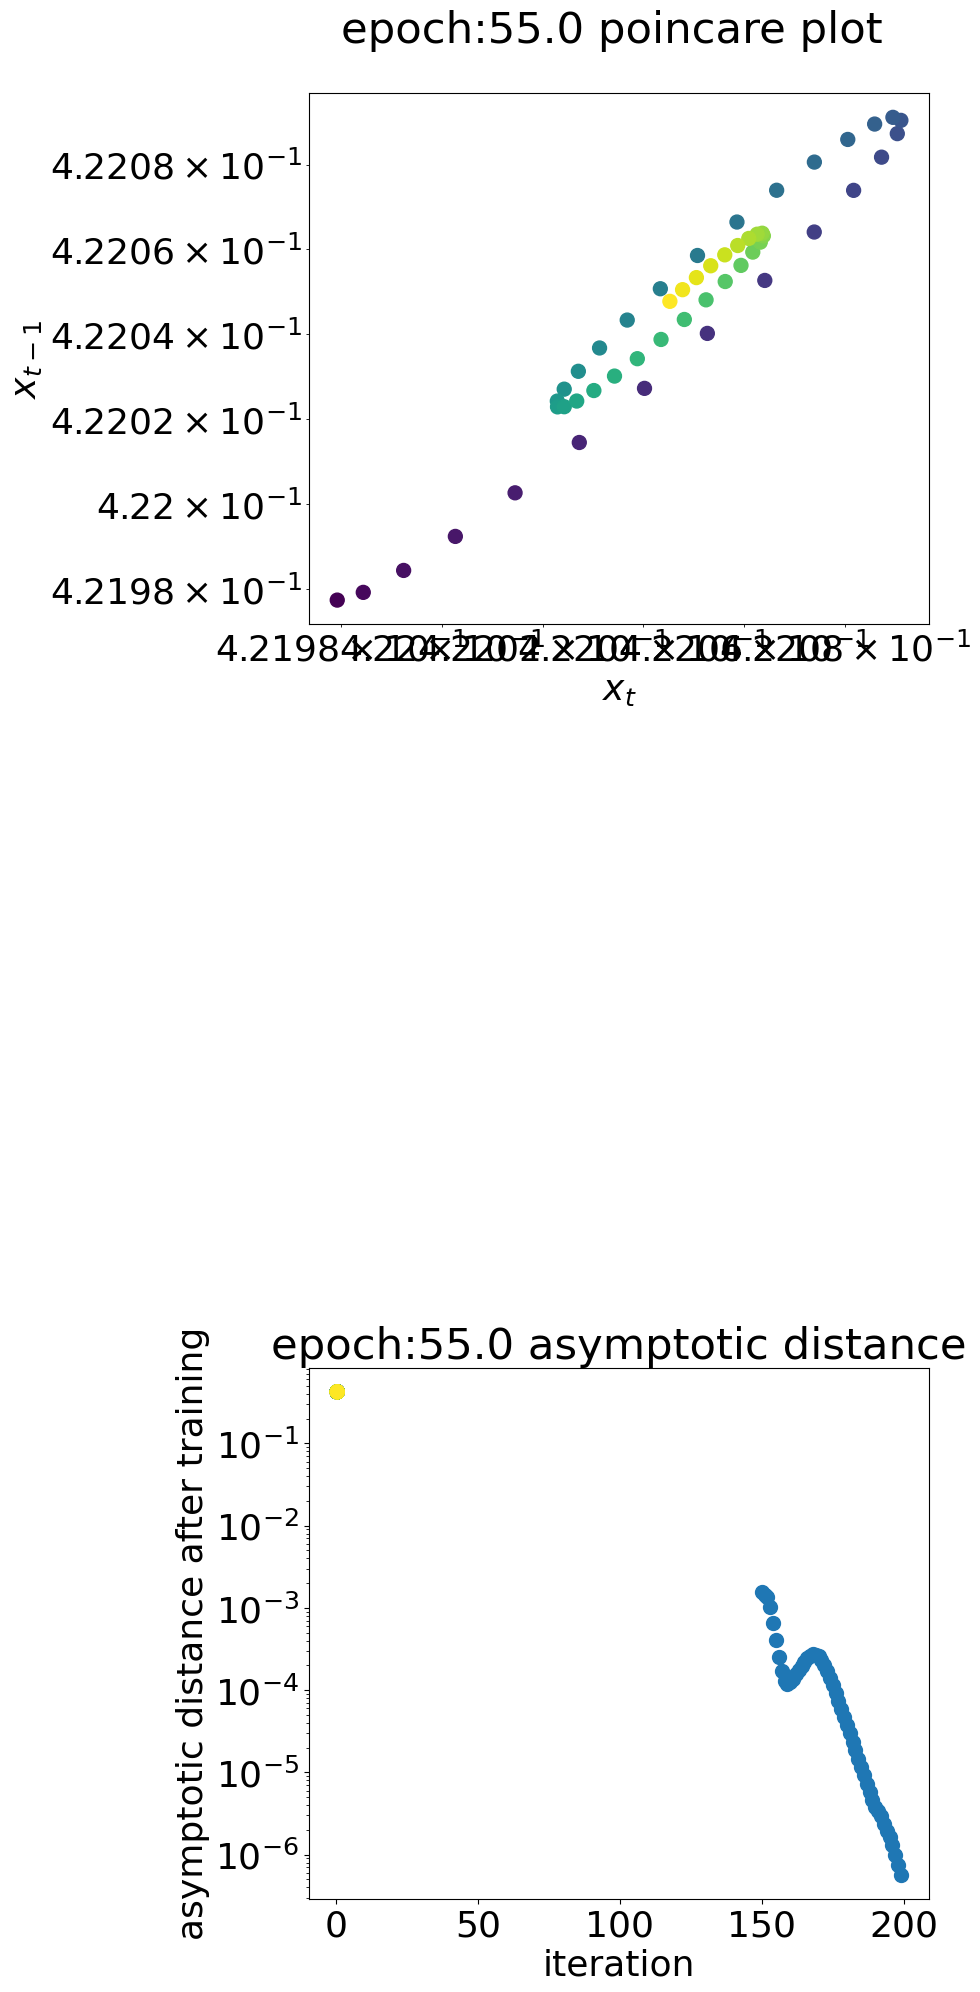

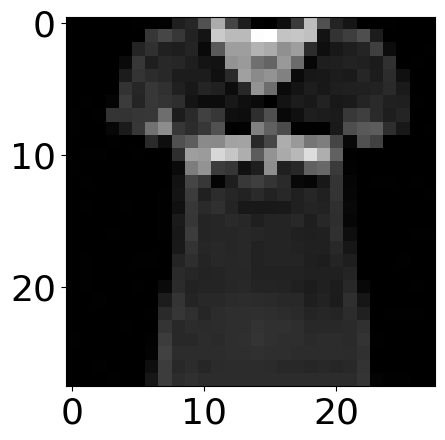

asymptotic image input epoch:60.jpg
percentage of chaos: 0.0
epoch : 61/100, training loss = 0.014430, validation loss = 0.016301
epoch : 62/100, training loss = 0.014579, validation loss = 0.017278
epoch : 63/100, training loss = 0.014978, validation loss = 0.016962
epoch : 64/100, training loss = 0.014972, validation loss = 0.016526
epoch : 65/100, training loss = 0.014632, validation loss = 0.016395
[0.3121011139572918, 0.3121011137115398, 0.3121011134509761, 0.31210111319233463, 0.31210111294863396, 0.312101112729304, 0.3121011125404712, 0.31210111238535443, 0.312101112264726, 0.3121011121773998, 0.31210111212071645, 0.31210111209099944, 0.3121011120839659, 0.31210111209508035, 0.3121011121198444, 0.3121011121540228, 0.3121011121938061, 0.31210111223591713, 0.3121011122776656, 0.31210111231696147, 0.31210111235229354, 0.3121011123826832, 0.3121011124076197, 0.31210111242698607, 0.31210111244098, 0.31210111245003525, 0.31210111245474853, 0.31210111245581323, 0.31210111245396244, 0.3

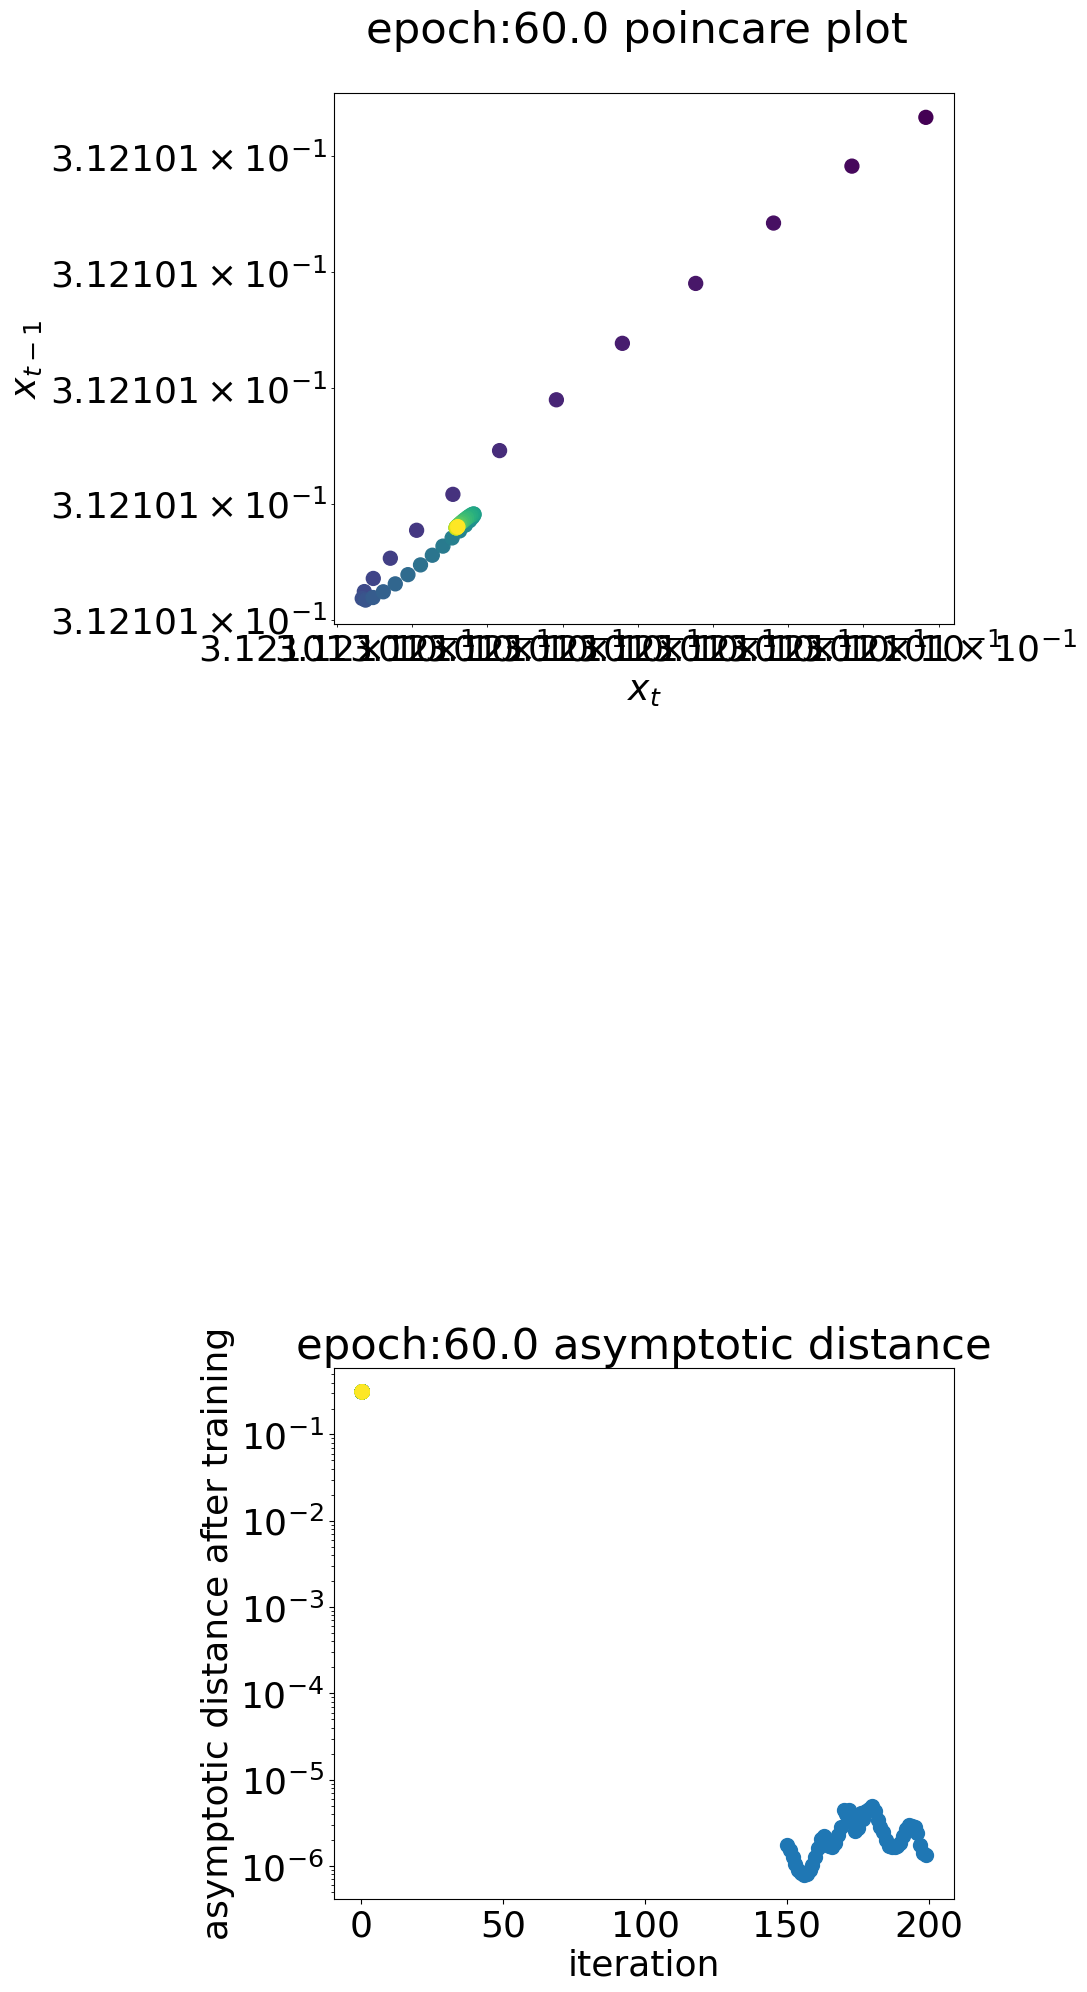

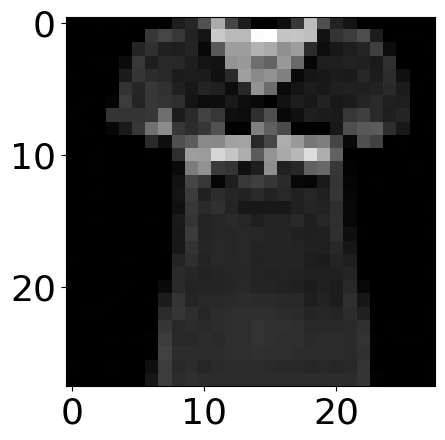

asymptotic image input epoch:65.jpg
percentage of chaos: 0.05
epoch : 66/100, training loss = 0.014191, validation loss = 0.015852
epoch : 67/100, training loss = 0.013704, validation loss = 0.015667
epoch : 68/100, training loss = 0.013632, validation loss = 0.015951
epoch : 69/100, training loss = 0.013777, validation loss = 0.016383
epoch : 70/100, training loss = 0.014098, validation loss = 0.017118
[0.510760152692351, 0.510760152692351, 0.510760152692351, 0.510760152692351, 0.510760152692351, 0.510760152692351, 0.510760152692351, 0.510760152692351, 0.510760152692351, 0.510760152692351, 0.510760152692351, 0.510760152692351, 0.510760152692351, 0.510760152692351, 0.510760152692351, 0.510760152692351, 0.510760152692351, 0.510760152692351, 0.510760152692351, 0.510760152692351, 0.510760152692351, 0.510760152692351, 0.510760152692351, 0.5107601526923509, 0.510760152692351, 0.510760152692351, 0.510760152692351, 0.510760152692351, 0.510760152692351, 0.510760152692351, 0.510760152692351, 0.

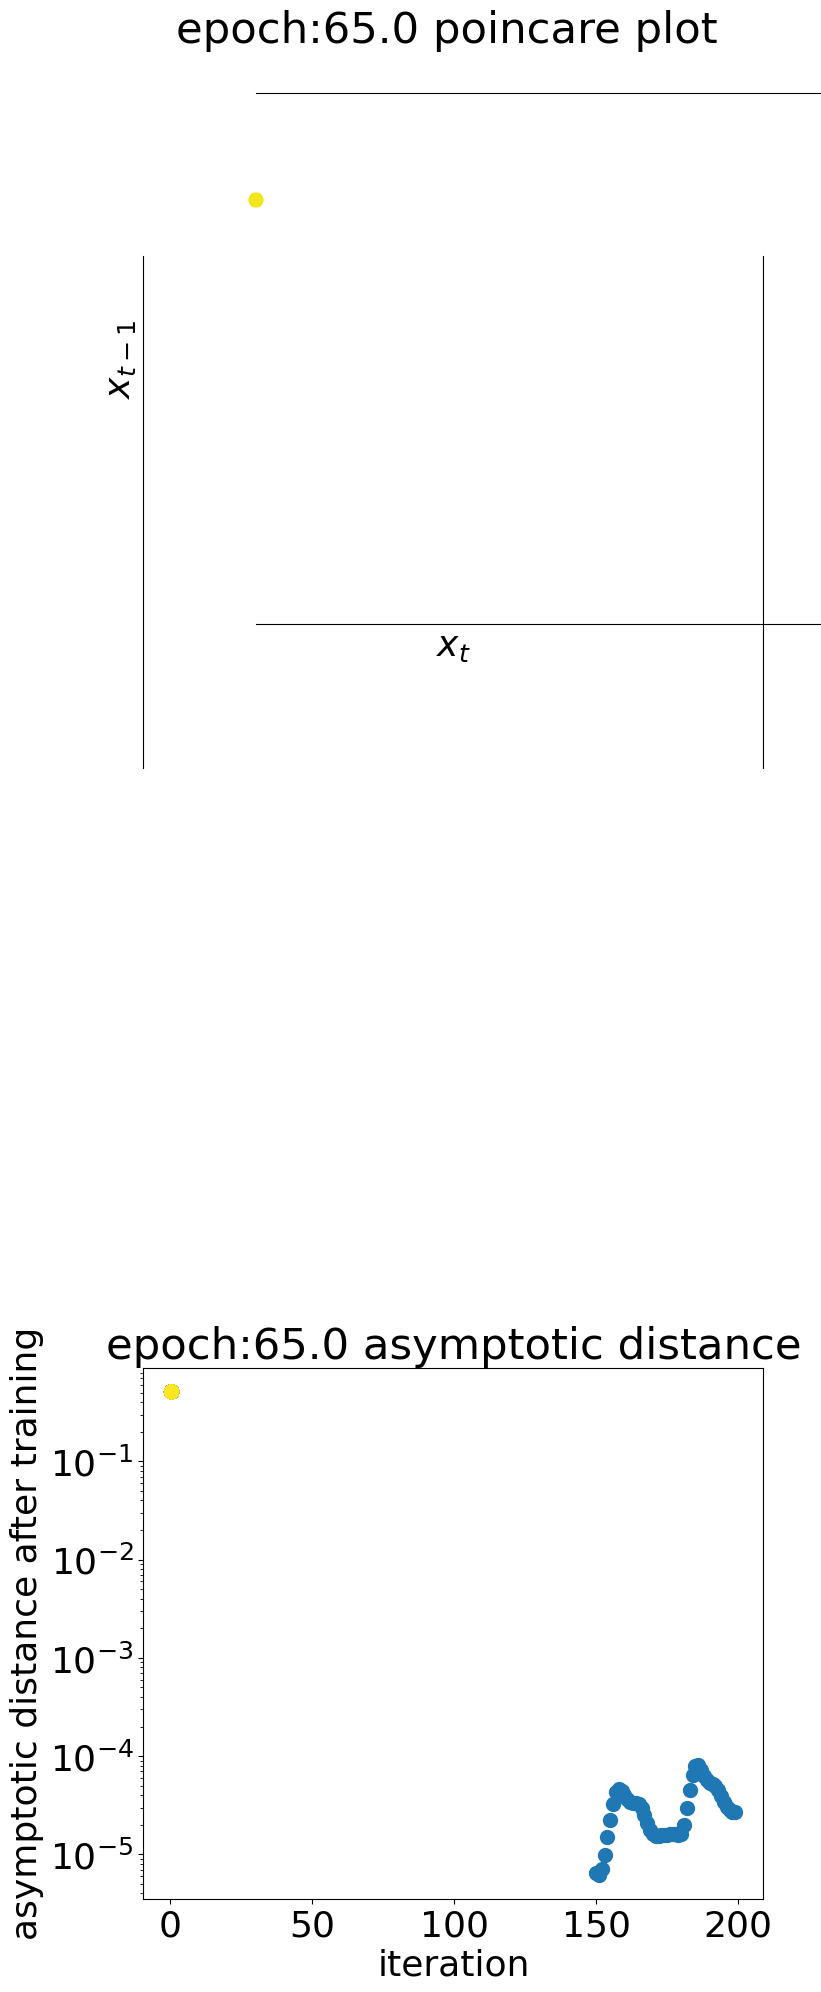

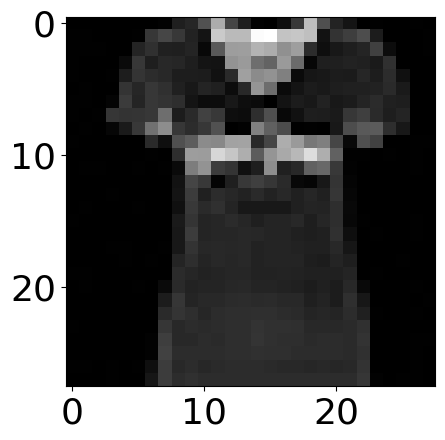

asymptotic image input epoch:70.jpg
percentage of chaos: 0.0
epoch : 71/100, training loss = 0.014164, validation loss = 0.015675
epoch : 72/100, training loss = 0.013984, validation loss = 0.016613
epoch : 73/100, training loss = 0.014170, validation loss = 0.016569
epoch : 74/100, training loss = 0.014327, validation loss = 0.015505
epoch : 75/100, training loss = 0.014547, validation loss = 0.015606
[0.40700128355849413, 0.4070012841816224, 0.40700128473088315, 0.407001285200139, 0.40700128558954257, 0.40700128590351947, 0.40700128614916437, 0.4070012863350039, 0.4070012864700793, 0.4070012865632915, 0.4070012866229646, 0.4070012866565798, 0.4070012866706393, 0.4070012866706273, 0.4070012866610381, 0.4070012866454493, 0.40700128662662055, 0.40700128660660545, 0.4070012865868663, 0.407001286568383, 0.4070012865517551, 0.40700128653728995, 0.40700128652507966, 0.4070012865150651, 0.40700128650708706, 0.40700128650092693, 0.4070012864963375, 0.40700128649306566, 0.4070012864908676, 0.4

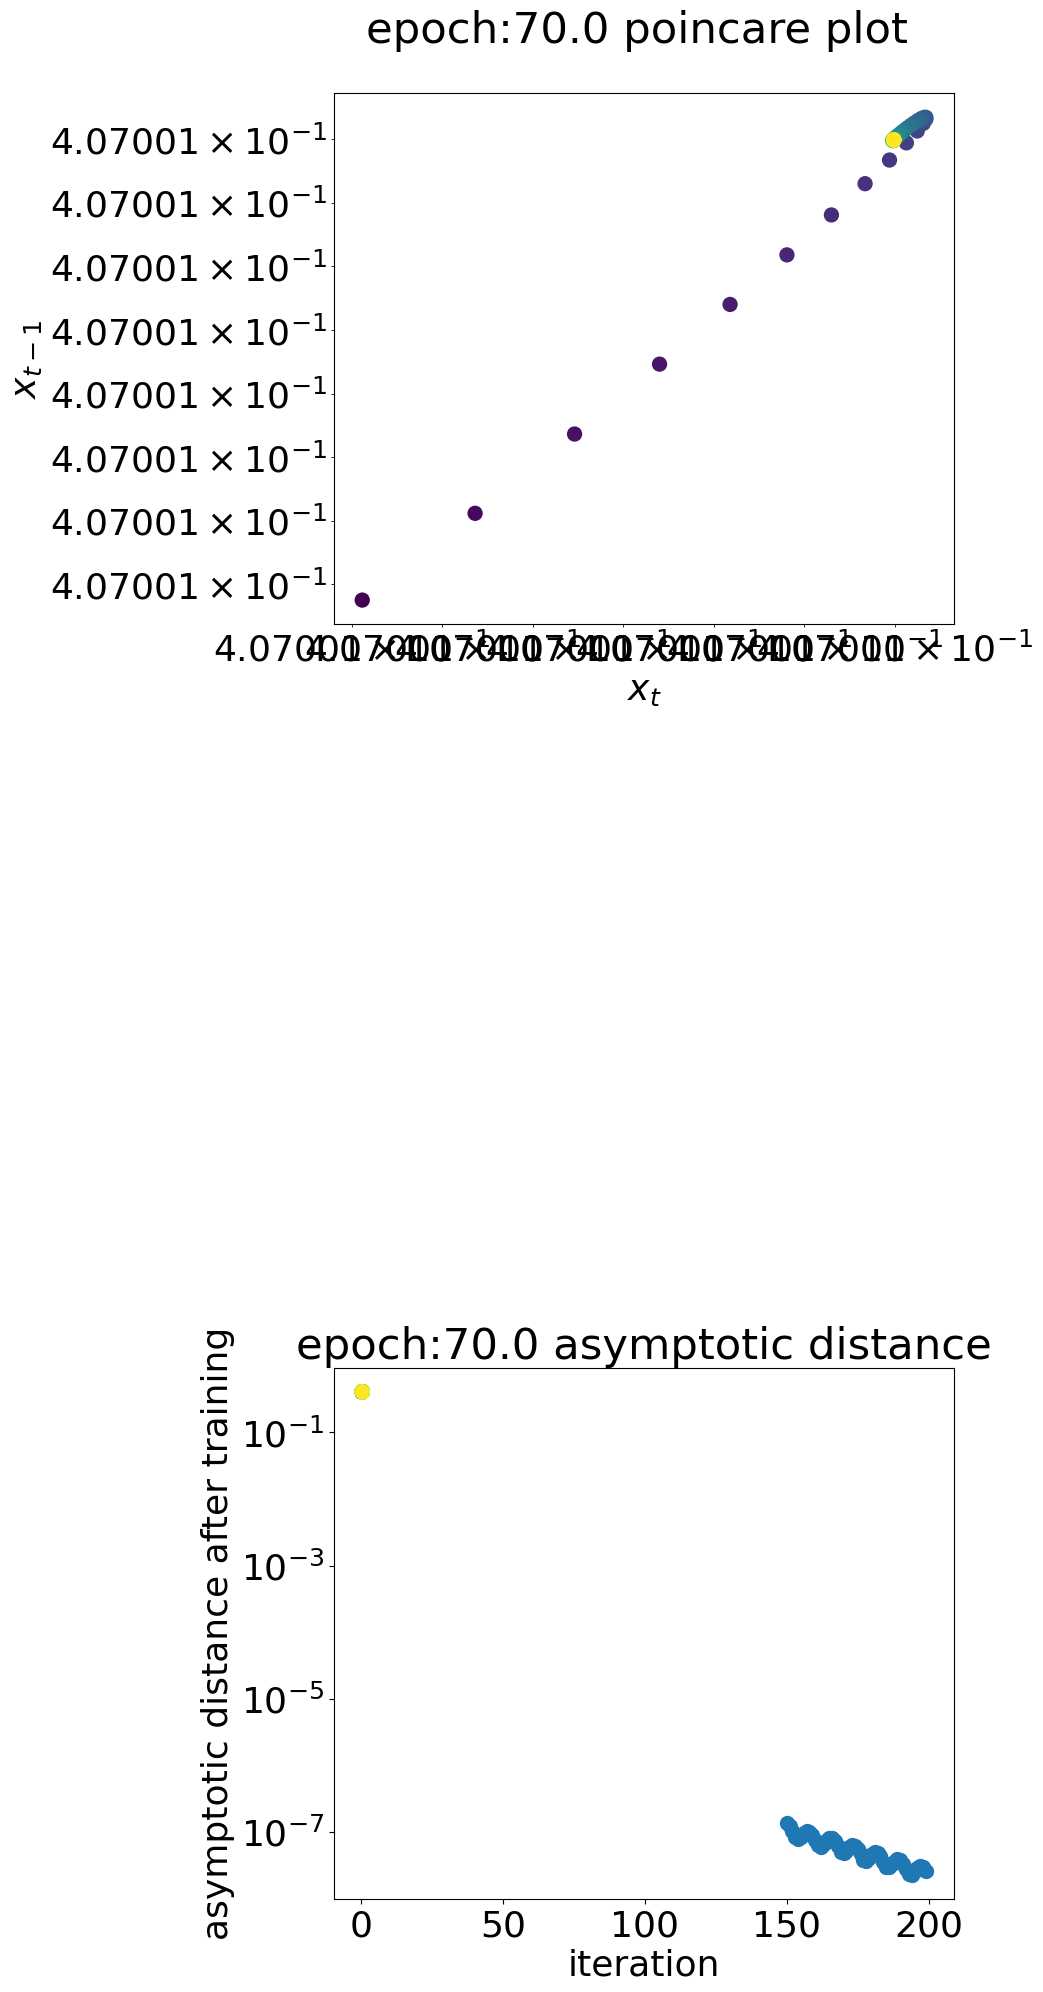

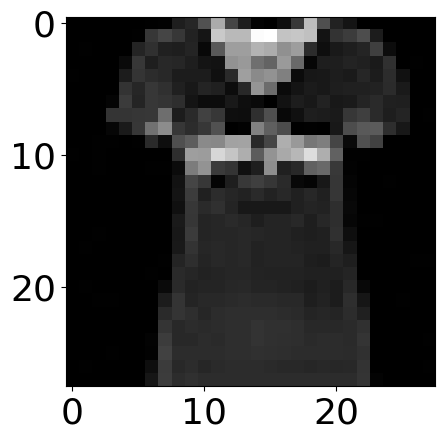

asymptotic image input epoch:75.jpg
percentage of chaos: 0.0
epoch : 76/100, training loss = 0.014850, validation loss = 0.015759
epoch : 77/100, training loss = 0.014583, validation loss = 0.015841
epoch : 78/100, training loss = 0.014219, validation loss = 0.015523
epoch : 79/100, training loss = 0.013737, validation loss = 0.015131
epoch : 80/100, training loss = 0.013477, validation loss = 0.015176
[0.2366153043068116, 0.2366153043068116, 0.23661530430681163, 0.23661530430681163, 0.23661530430681166, 0.23661530430681166, 0.23661530430681166, 0.23661530430681166, 0.23661530430681166, 0.23661530430681166, 0.23661530430681163, 0.23661530430681166, 0.23661530430681163, 0.23661530430681163, 0.2366153043068116, 0.23661530430681163, 0.23661530430681163, 0.23661530430681163, 0.23661530430681163, 0.23661530430681163, 0.23661530430681163, 0.23661530430681166, 0.23661530430681163, 0.23661530430681163, 0.23661530430681163, 0.23661530430681163, 0.2366153043068116, 0.23661530430681163, 0.2366153

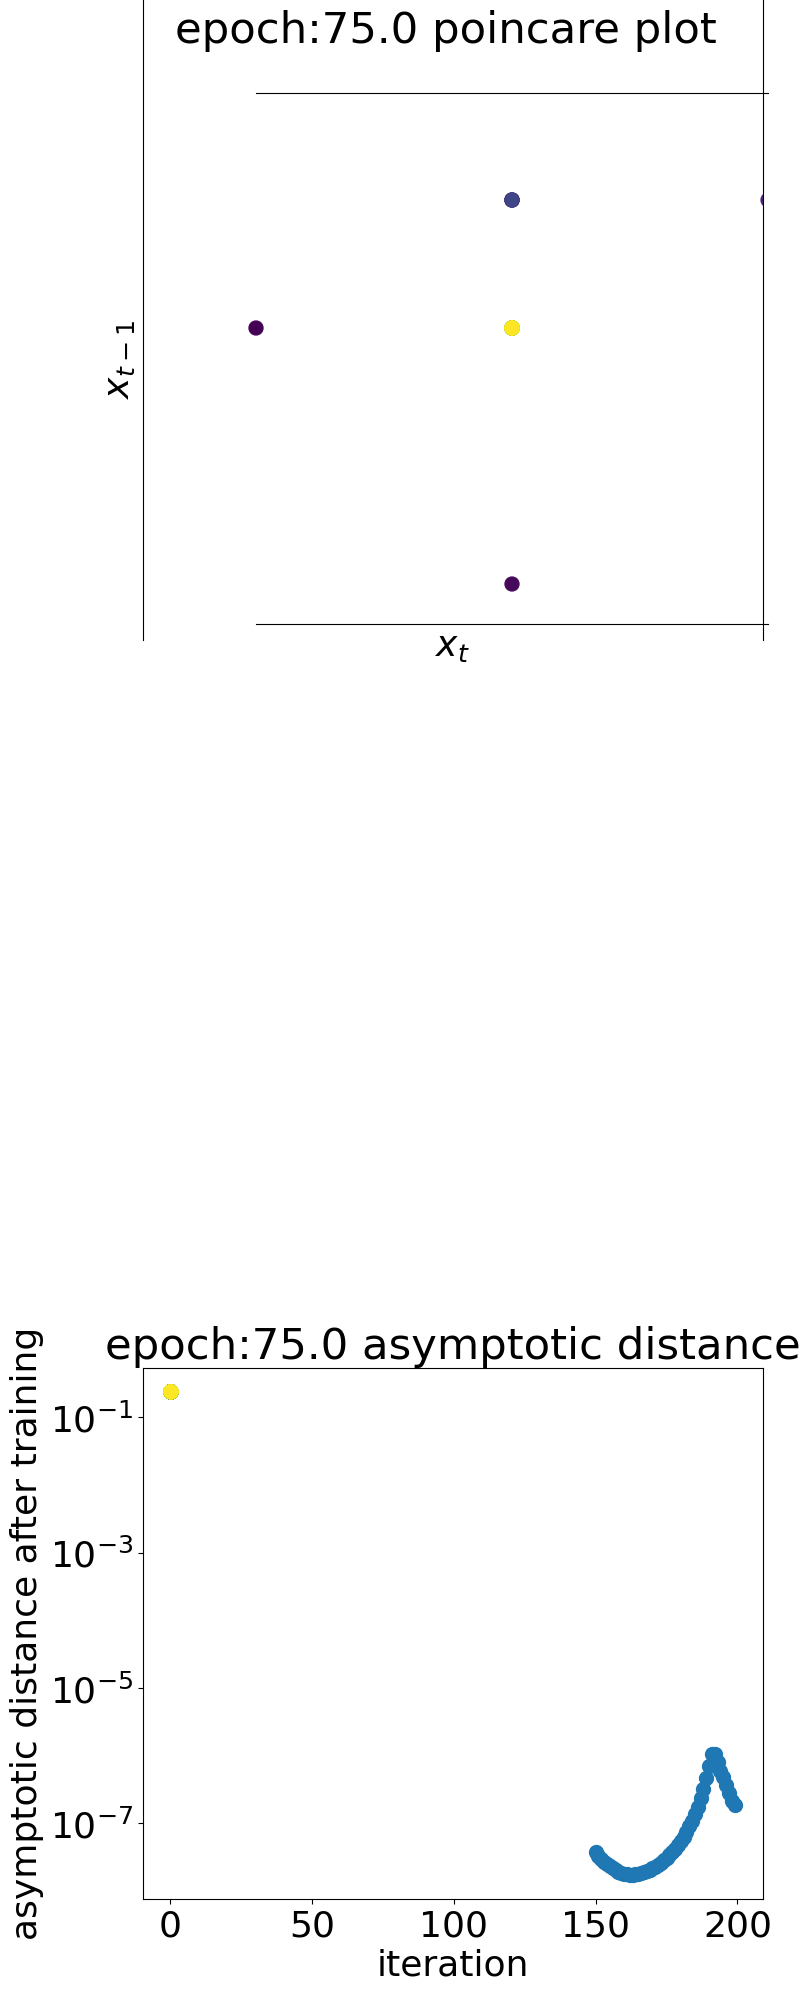

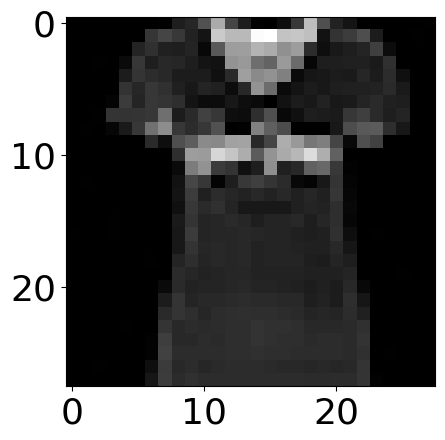

asymptotic image input epoch:80.jpg
percentage of chaos: 0.1
epoch : 81/100, training loss = 0.013519, validation loss = 0.015280
epoch : 82/100, training loss = 0.013846, validation loss = 0.015191
epoch : 83/100, training loss = 0.013904, validation loss = 0.015252
epoch : 84/100, training loss = 0.013863, validation loss = 0.016797
epoch : 85/100, training loss = 0.014051, validation loss = 0.015741
[0.38947274463274373, 0.38947274463274356, 0.38947274463274356, 0.38947274463274356, 0.3894727446327435, 0.3894727446327435, 0.3894727446327435, 0.3894727446327435, 0.3894727446327435, 0.3894727446327435, 0.3894727446327435, 0.3894727446327435, 0.3894727446327435, 0.3894727446327435, 0.3894727446327435, 0.3894727446327435, 0.3894727446327435, 0.3894727446327435, 0.3894727446327435, 0.3894727446327435, 0.3894727446327435, 0.3894727446327435, 0.3894727446327435, 0.3894727446327435, 0.3894727446327435, 0.3894727446327435, 0.3894727446327435, 0.3894727446327435, 0.3894727446327435, 0.3894727

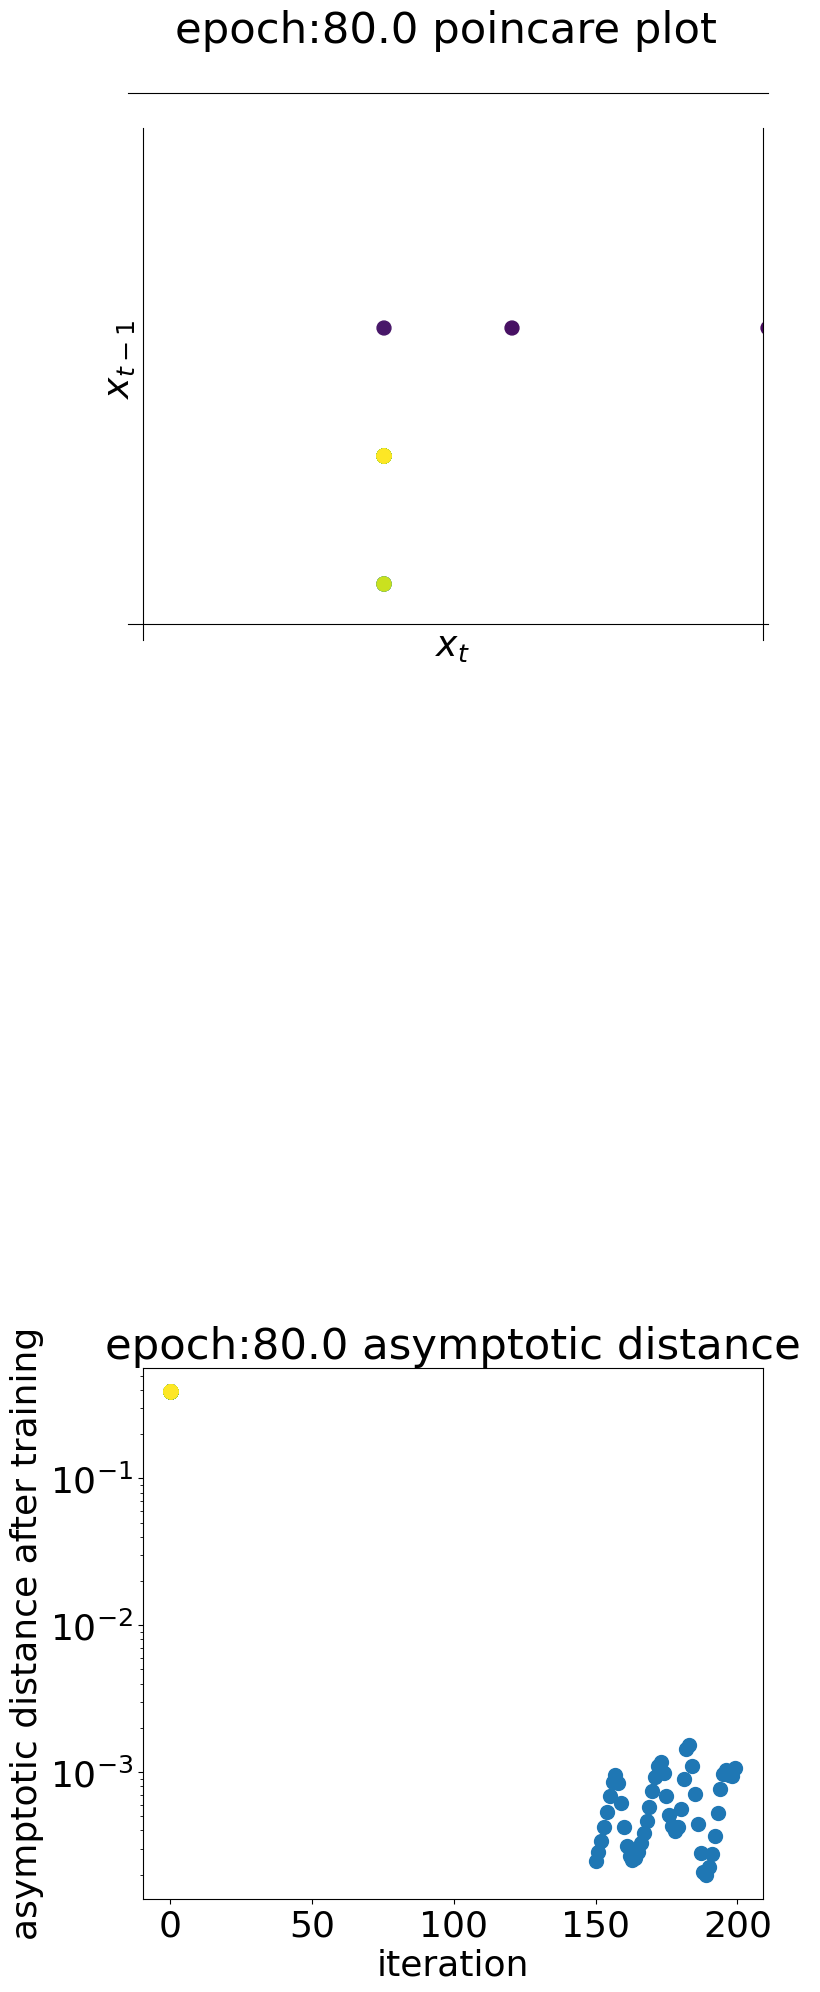

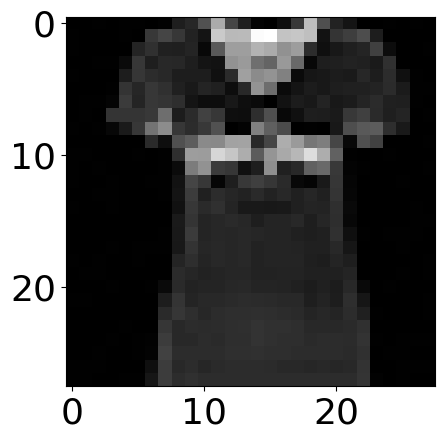

asymptotic image input epoch:85.jpg
percentage of chaos: 0.0
epoch : 86/100, training loss = 0.014186, validation loss = 0.015499
epoch : 87/100, training loss = 0.014521, validation loss = 0.015778
epoch : 88/100, training loss = 0.014872, validation loss = 0.015682
epoch : 89/100, training loss = 0.014695, validation loss = 0.015760
epoch : 90/100, training loss = 0.014475, validation loss = 0.015626
[0.5656095917484292, 0.5635863205397172, 0.5628666659754405, 0.5625812682807901, 0.5622551800069767, 0.5618824094669682, 0.5619139835977942, 0.5630622976121089, 0.5659688994699923, 0.571154136529178, 0.5784385959665201, 0.5854887664907684, 0.5892944799824122, 0.588821190260058, 0.585128133866286, 0.5797966479930747, 0.5738944096290289, 0.5684942973067386, 0.5649372216621475, 0.5633259190916982, 0.562781967535937, 0.5625130926560535, 0.5621578272858839, 0.5618269601958219, 0.5620649806593253, 0.5635918875754864, 0.5670149133124482, 0.5727971987361123, 0.5803225288429316, 0.586808566470845

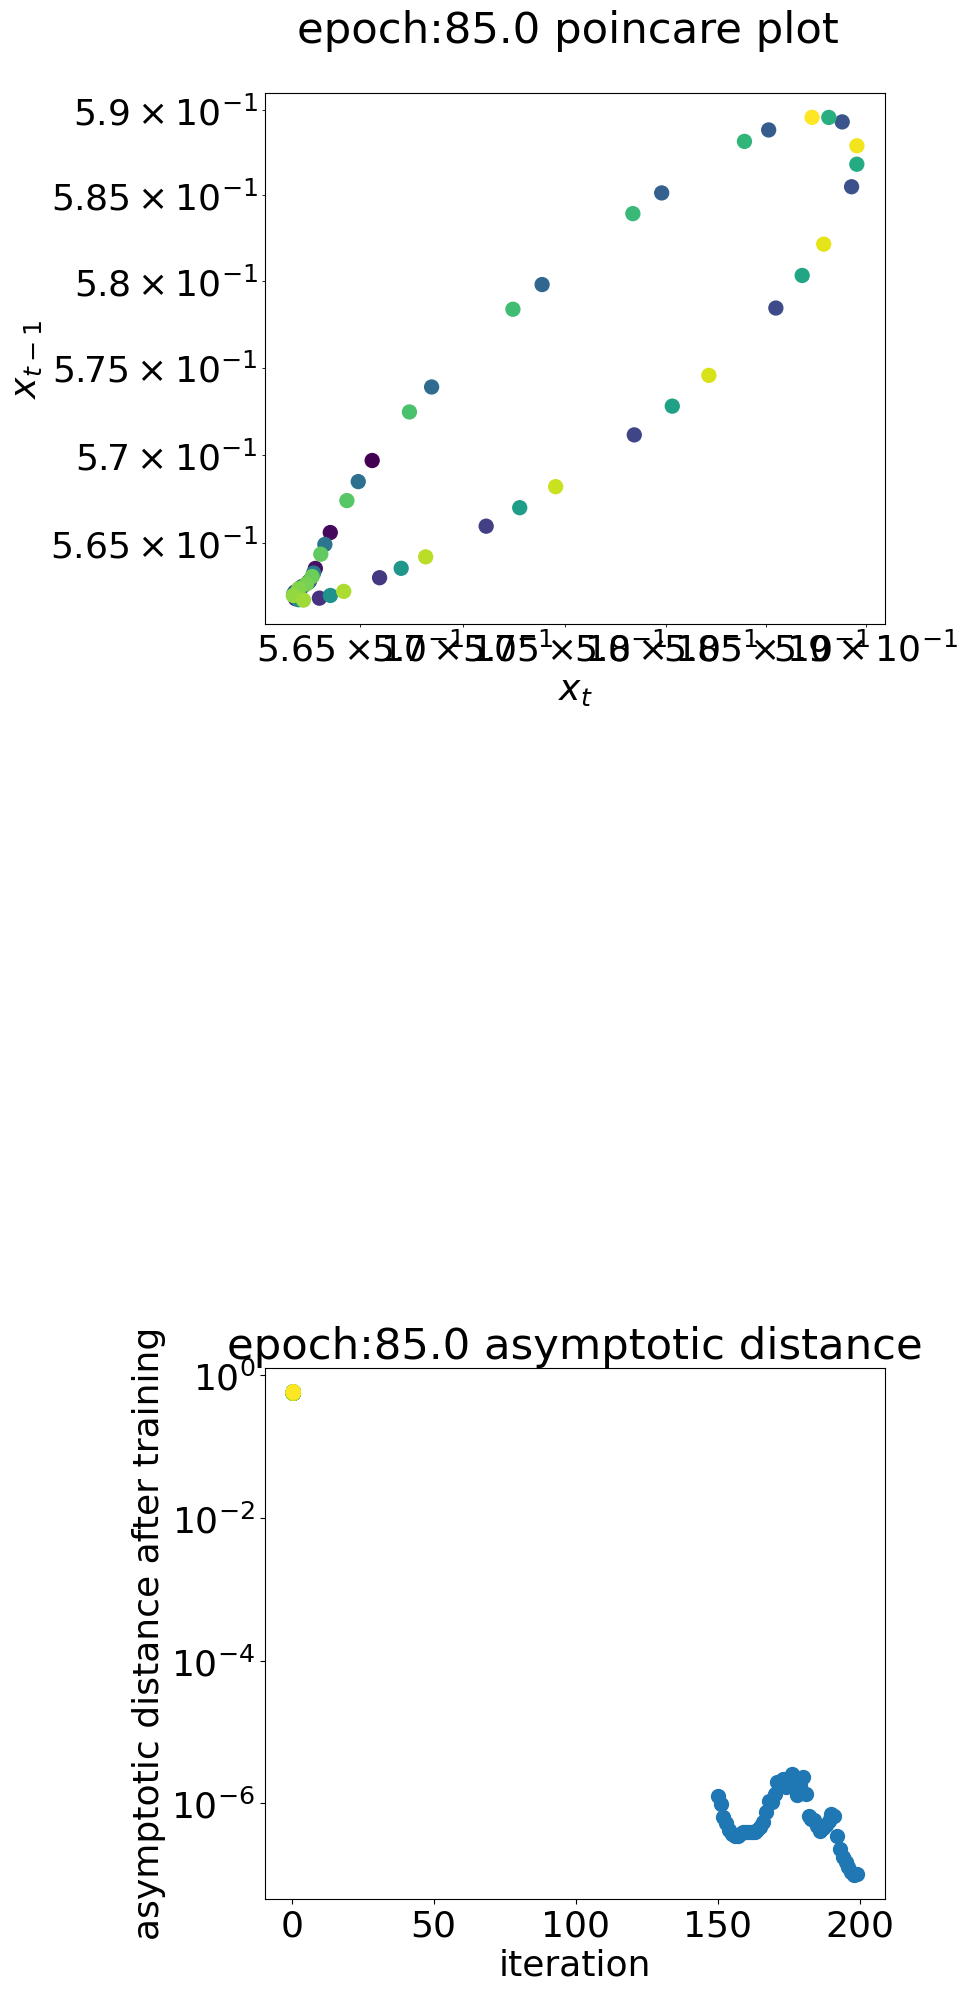

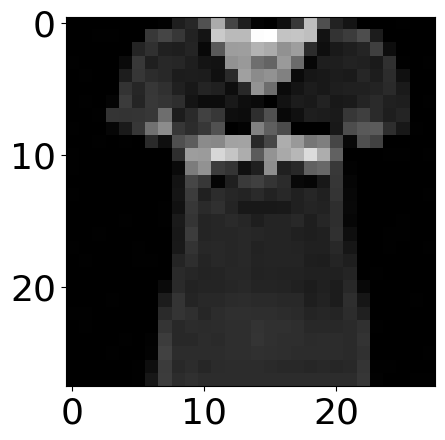

asymptotic image input epoch:90.jpg
percentage of chaos: 0.1
epoch : 91/100, training loss = 0.014192, validation loss = 0.015479
epoch : 92/100, training loss = 0.013793, validation loss = 0.015155
epoch : 93/100, training loss = 0.013431, validation loss = 0.014990
epoch : 94/100, training loss = 0.013356, validation loss = 0.015048
epoch : 95/100, training loss = 0.013471, validation loss = 0.015032
[0.5734798646395876, 0.5812341763598137, 0.5866855254717093, 0.5879468744421357, 0.5873054236201996, 0.5857374687268858, 0.5820925902303262, 0.5759419965479945, 0.5728023450502459, 0.5687729513090436, 0.5583674921573284, 0.5517795633319772, 0.5364022336923815, 0.5148123908379316, 0.5056854919428138, 0.5042960099878648, 0.5058566129518696, 0.5042555364463019, 0.49919359910965394, 0.49641288396506944, 0.5001189464041462, 0.5135353877672105, 0.5314017191518078, 0.5452309528449806, 0.5514823902959088, 0.5536011366255092, 0.5552327871540358, 0.5577424197294297, 0.5615093894445823, 0.566663244

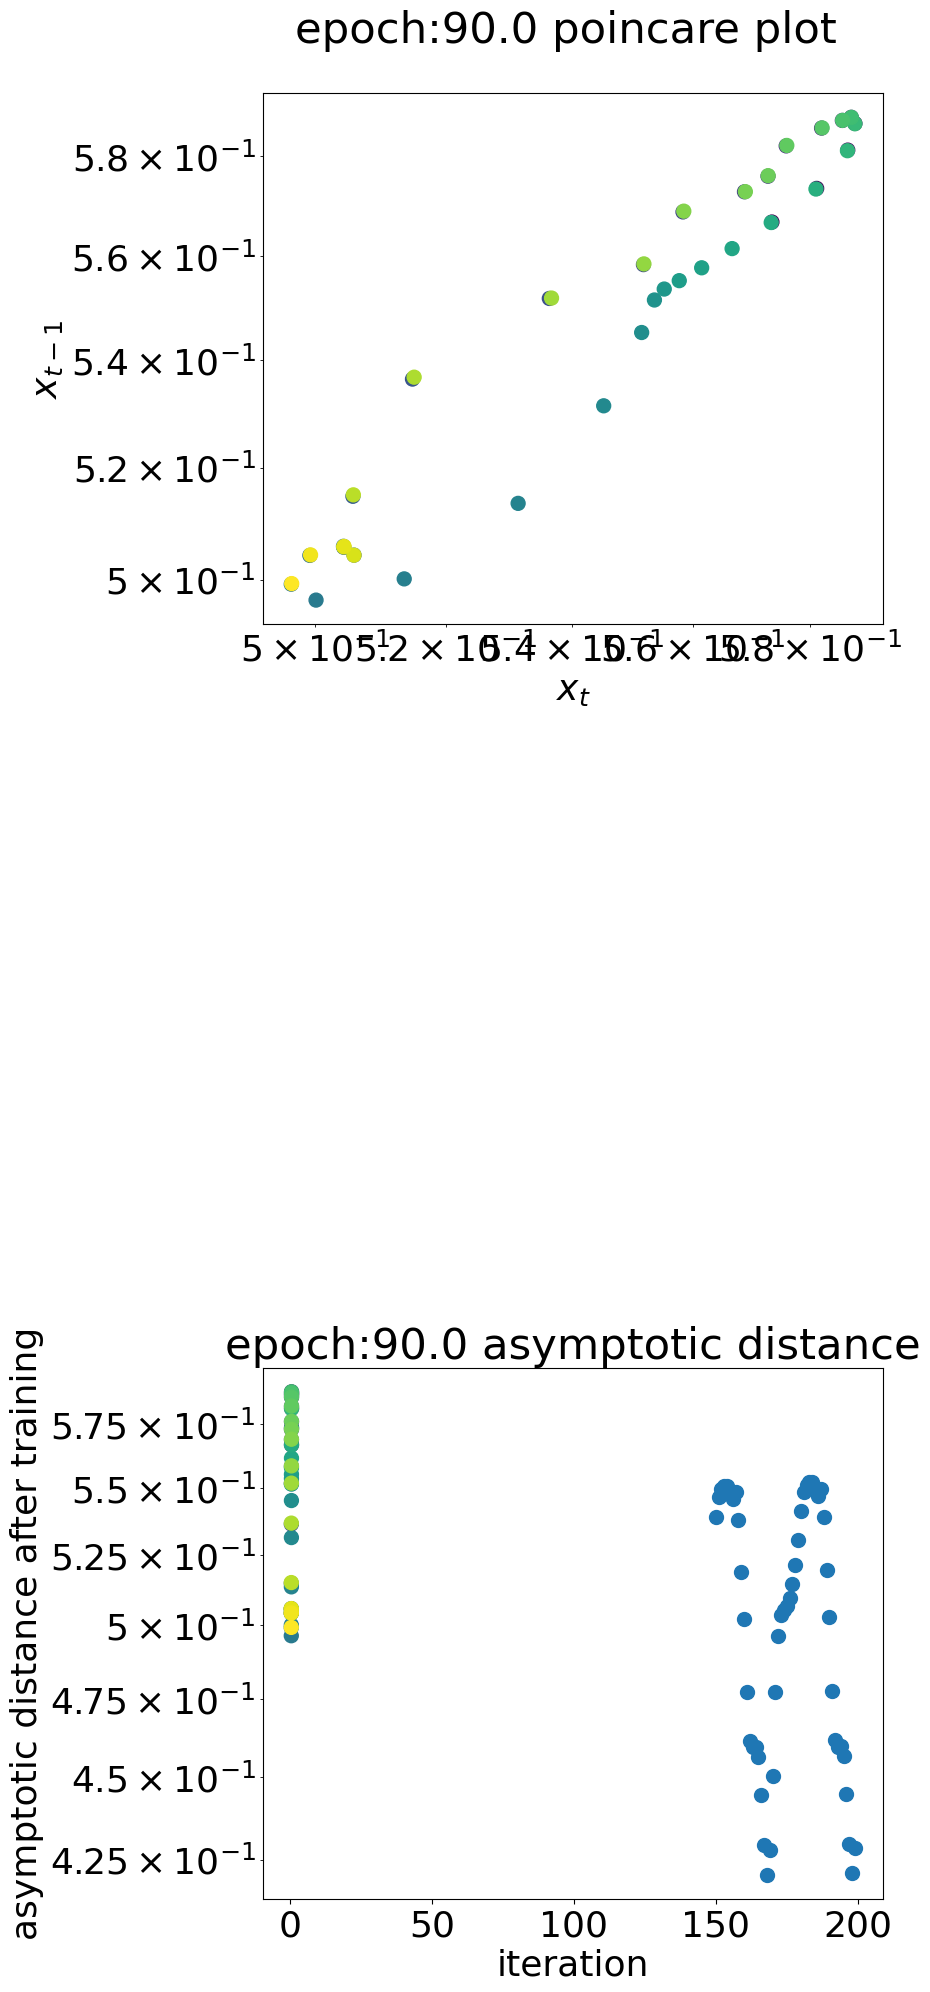

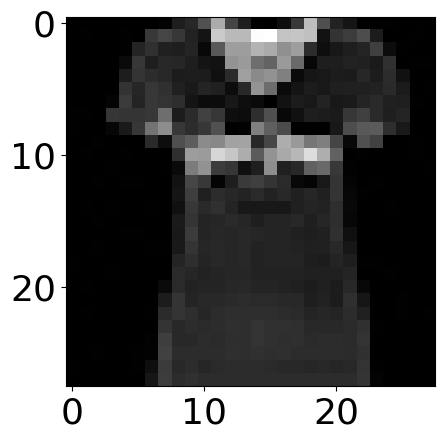

asymptotic image input epoch:95.jpg
percentage of chaos: 0.1
epoch : 96/100, training loss = 0.013677, validation loss = 0.015037
epoch : 97/100, training loss = 0.013744, validation loss = 0.015231
epoch : 98/100, training loss = 0.013760, validation loss = 0.015120
epoch : 99/100, training loss = 0.013817, validation loss = 0.015474
epoch : 100/100, training loss = 0.013753, validation loss = 0.015563
[0.4999629302290692, 0.4999629302290691, 0.4999629302290691, 0.4999629302290691, 0.4999629302290691, 0.4999629302290691, 0.4999629302290691, 0.4999629302290691, 0.4999629302290691, 0.49996293022906907, 0.4999629302290691, 0.4999629302290691, 0.4999629302290691, 0.4999629302290691, 0.4999629302290691, 0.4999629302290691, 0.4999629302290691, 0.4999629302290691, 0.4999629302290691, 0.4999629302290691, 0.4999629302290691, 0.4999629302290691, 0.4999629302290691, 0.4999629302290691, 0.4999629302290691, 0.4999629302290691, 0.4999629302290691, 0.4999629302290691, 0.49996293022906907, 0.49996293

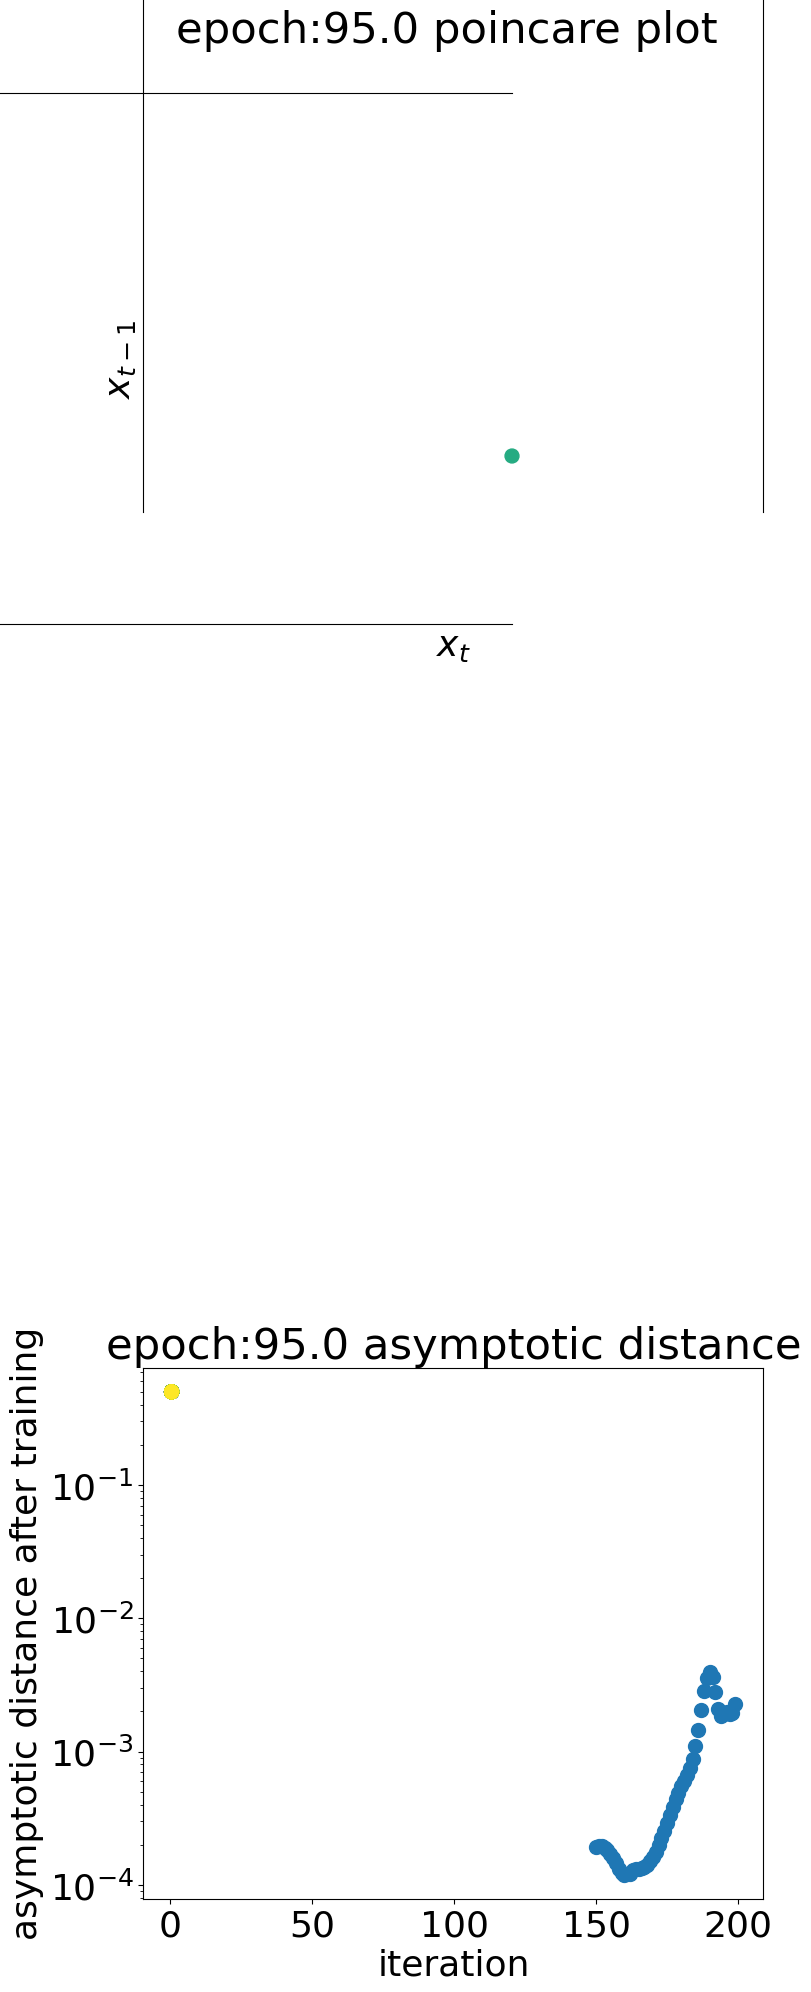

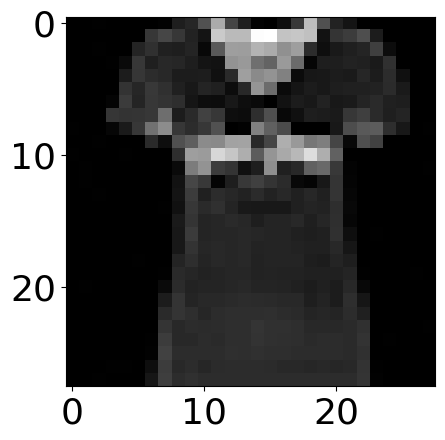

asymptotic image input epoch:100.jpg
percentage of chaos: 0.15
3273.932916164398
[1.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.05, 0.0, 0.0, 0.1, 0.0, 0.1, 0.1, 0.15]


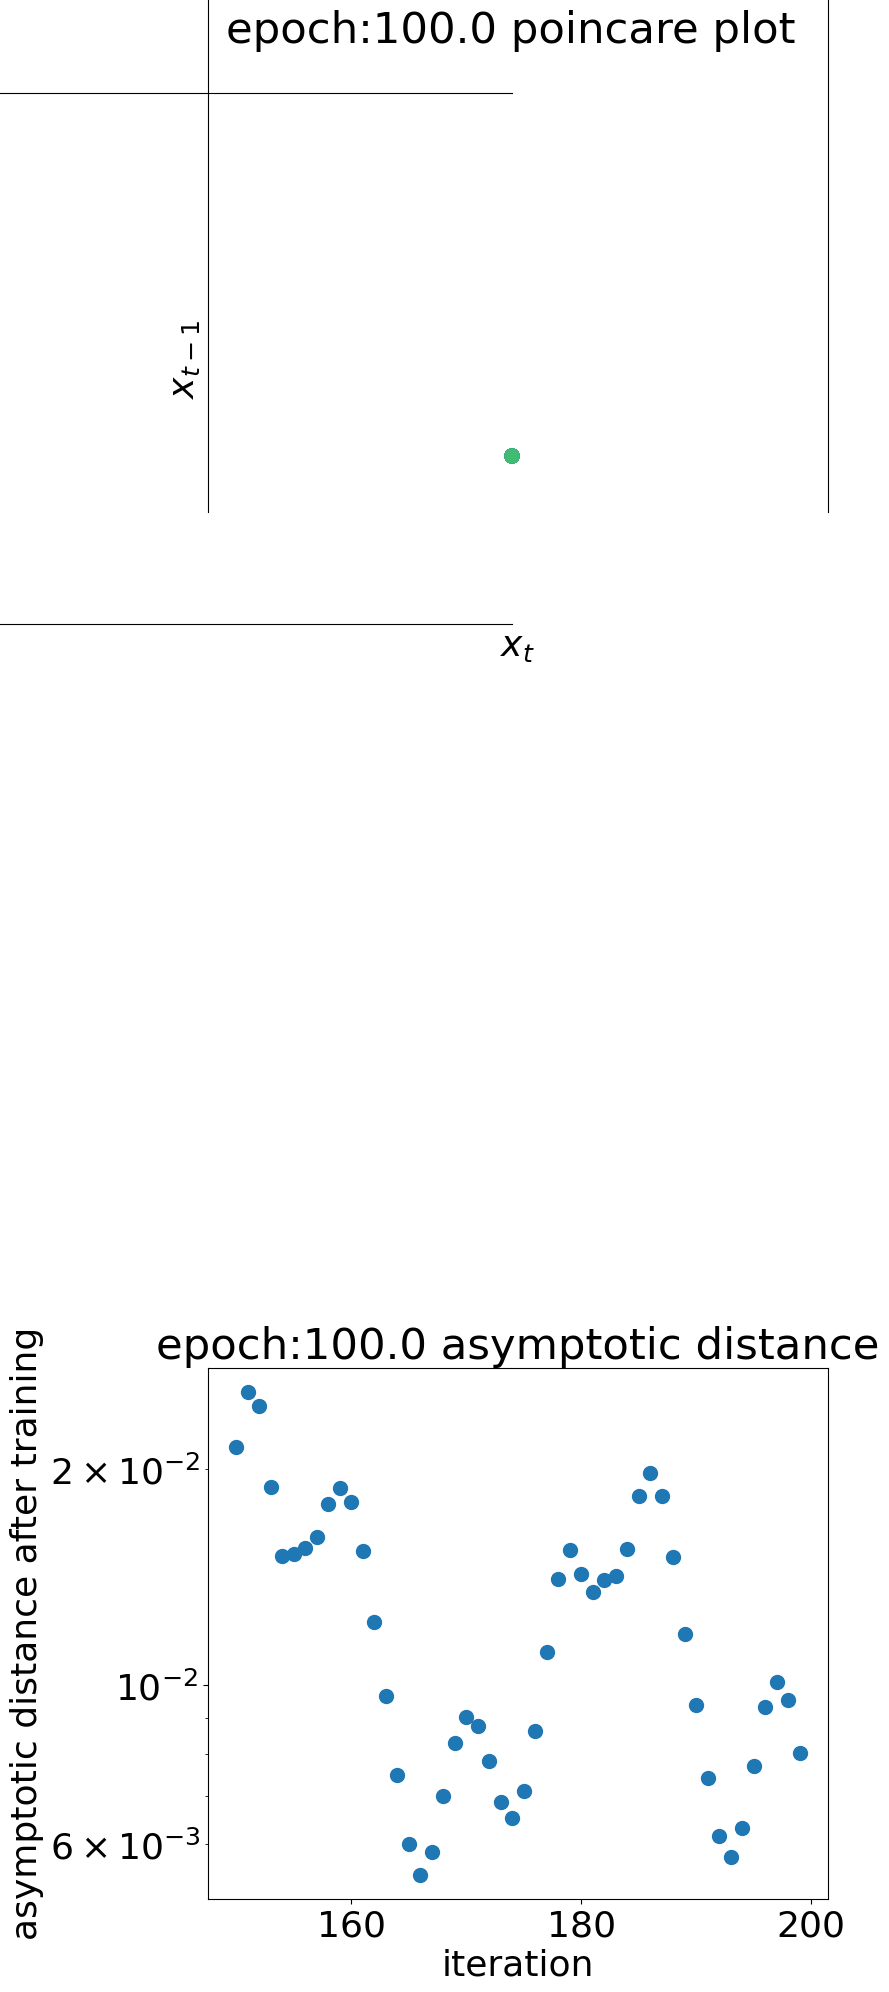

In [10]:
##TODO at specific epoch,save the weights and use for all images to see the effect on output
spectral_radiuses=[]
average_jacobian=[]
xinfinity=[]
xpinfinity=[]
training_loss=[]
validation_loss=[]
asymptotic_dist=[]
cycledectection=BrentCycleDetection(10**-3)
#diverge=[]
start=time.time()
print("running")
#strength=0.1
init_compute=True
chao=[]
noise_print=False
for epoch in range(epochs):
    loss = 0


    for batch_features, _ in train_loader:
        # reshape mini-batch data to [1000, 784] matrix
        # load it to the active device
        input_image =add_gaussian_noise(batch_features,noise_strength).view(batch_size, -1).to(device)
        
        
        batch_feature=batch_features.view(batch_size,-1)
        #input_image =add_powerlaw_noise(input_size,batch_size,noise_strength,batch_feature).view(batch_size, -1).to(device)
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
 
        optimizer.zero_grad()
        
        # compute reconstructions
        #outputs = model(batch_features.view(batch_size,-1).to(device))
        outputs = model(input_image)
        
        # compute training reconstruction loss
        
 
        train_loss = criterion(outputs,batch_feature.to(device))
        
        if init_compute==True and epoch%interval==0:
                #print("here")Trues 
                #print(train_loss)
            save_image=input_image
                #perturbed_inputs=add_gaussian_noise(x_train,perturbation_strength)
            perturbed_inputs=add_gaussian_noise(input_image,perturbation_strength)
                #print("perturbed_inputs")
                #print(torch.norm(perturbed_inputs))
            cutoff=[]
            for j in range(no_of_images):
                cutoff.append(torch.norm(perturbed_inputs[j]-input_image[j]))
            model_clone=AE(input_size,input_size,hidden_state_size,no_of_layer)
            model_clone.load_state_dict(copy.deepcopy(model.state_dict()))
            #model_clone.eval() 
            #print(cutoff)
            x_train_perturbed,y_pred_perturbed,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,perturbed_inputs,epoch)
            x_train_unperturbed,y_pred_unperturbed,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,input_image,epoch)
            #print("there")
            ##print(torch.norm(y_pred_perturbed))
            #print(torch.norm(y_pred_unperturbed))
            distance,hidden,chaos=asymptotic_iteration(model_clone,y_pred_unperturbed,y_pred_perturbed,no_of_repetition,no_of_images,cutoff)
                
            asymptotic_dist.append(distance[-1])
            chao.append(chaos)
            
            plt.scatter(x=np.arange(asymptotic_repetition,asymptotic_repetition+no_of_repetition),y=distance,s=100)
            plt.xlabel("iteration")
            plt.ylabel("asymptotic distance")
            plt.yscale("log")
            plt.title("epoch:{:.1f} asymptotic distance before training".format(epoch))
            np.savetxt("asymptotic distance"+str(epoch)+".txt",distance)
            plt.savefig("initial asymptotic state.jpg")
            plt.show()
            #average_jacobian=[]
            #spectral_radiuses=[]
            init_compute=False
        # compute accumulated gradients
        train_loss.backward()

        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        torch.save(model.state_dict(), "epoch:"+str(epoch+1)+".pt")
        
    # compute the epoch training loss
    loss = loss / len(train_loader)
    training_loss.append(loss)

    
    with torch.no_grad():
        accuracy=validation(test_loader)
        validation_loss.append(accuracy)
        
        
    print("epoch : {}/{}, training loss = {:.6f}, validation loss = {:.6f}".format(epoch+1 , epochs, loss,accuracy))
    if (epoch)%interval==interval-1:
        dimension_vector=torch.ones(input_size).to(device)
        xt,xtminus=poincare_plot(model_clone,x_train_unperturbed[0],dimension_vector,no_of_repetition,colour,epoch)
        print(xt)
        mu,lam=cycledectection.detect_cycle(xt)
        cycledectection.print_result()
        
        plt.scatter(xt,xtminus,c=np.arange(1,no_of_repetition+1),s=100)
        plt.show()
        name="asymptotic image input"
        visualisation(input_image.view(batch_size,-1)[0].cpu().detach(),epoch,name,True)
        x_train,y_pred,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,input_image,epoch)
        perturbed_input=add_gaussian_noise(save_image,perturbation_strength) #generate perturbed inputs
        cutoffs=[]
        for j in range(no_of_images):
            cutoffs.append(torch.norm(perturbed_input[j]-save_image[j]))
        #print(cutoffs)
        x_train_perturbed,y_pred_perturbed,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,perturbed_input,epoch)
        x_train_unperturbed,y_pred_unperturbed,average_jacobian,spectral_radiuses,model_clone=calculation(model,no_of_images,no_of_repetition,average_jacobian,spectral_radiuses,save_image,epoch)
        distance,hidden,chaos=asymptotic_iteration(model_clone,y_pred_unperturbed,y_pred_perturbed,no_of_repetition,no_of_images,cutoffs)
                

        dimension_vector=torch.ones(input_size).to(device)
        xt,xtminus=poincare_plot(model_clone,x_train_perturbed[0],dimension_vector,no_of_repetition,colour,epoch)
       
        
         #perturbed_inputs=add_gaussian_noise(x_train,perturbation_strength)
     
       
         #perturbed_inputs=add_powerlaw_noise(input_size,batch_size,perturbation_strength,x_train.cpu()).view(batch_size, -1).to(device)
         #distance,hidden,chaos=asymptotic_iteration(model_clone,x_train,perturbed_inputs,no_of_repetition,no_of_images,perturbation_strength)
        print("percentage of chaos:",chaos) 
        
        asymptotic_dist.append(distance[-1])
         #print(distance[-1])
        # inits=0
        # if epoch==epochs-1:
        #     for value in model.parameters():
        #          #print(key)
        #         plots=torch.flatten(value).cpu().detach().numpy()
        #         plt.hist(plots, density=True, bins='auto', histtype='stepfilled',cumulative=-1)
        #          #plt.title("model "+str(key)+"plot")
        #         plt.savefig("model "+str(inits)+"plot.jpg")
        #         np.savetxt("fianl weight"+str(inits)+".txt",value.cpu().detach().numpy())
        #         plt.show()
        #         inits+=1
        
        
        chao.append(chaos)
         #diverge.append(divergent/100)
        

        fig = plt.figure(figsize=(8,40))

        plt.subplot(5, 1, 1)
        plt.scatter(xt,xtminus,c=colour,s=100)
        plt.xlabel("$x_t$")
        plt.ylabel("$x_{t-1}$")
        plt.title("epoch:{:.1f} poincare plot ".format(epoch+1),y=1.08)
        plt.xscale("log")
        plt.yscale("log")
        
        plt.subplot(5, 1, 3)
        plt.scatter(np.arange(asymptotic_repetition,asymptotic_repetition+no_of_repetition),distance,s=100)
        plt.xlabel("iteration")
        plt.ylabel("asymptotic distance after training")
        np.savetxt("asymptotic distance"+str(epoch+1)+".txt",distance)
        plt.yscale("log")
        plt.title("epoch:{:.1f} asymptotic distance".format(epoch+1))
        
        
        # plt.subplot(5, 1, 5)
        # #plt.figure().set_figheight(8)
        # plt.scatter(hidden[:-1],hidden[1:],c=colour[:-1],s=100)
        # plt.xlabel("h_t")
        # plt.ylabel("$h_{t-1}$")
        # #plt.yscale("log")
        # plt.title("epoch:{:.1f} hidden layer".format(epoch+1),y=1.08)
        # plt.savefig("epoch:"+str(epoch+1)+"number of iteration:"+str(no_of_repetition)+".jpg",bbox_inches = 'tight')
        # plt.show()

        #torch.save(model.state_dict(), "epoch:"+str(epoch+1)+".pt")
       # name="asymptotic image output"
        #visualisation(y_pred.view(batch_size,-1)[0].cpu().detach(),epoch,name,True)
        #print(distance)
        
        #torch.save(model.state_dict(), "epoch:"+str(epoch+1)+".pt")
       # name="asymptotic image output"
        #visualisation(y_pred.view(batch_size,-1)[0].cpu().detach(),epoch,name,True)
        #print(distance)
        
end=time.time()
print(end-start)

print(chao)



[1.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.05, 0.0, 0.0, 0.0, 0.0, 0.05, 0.0, 0.0, 0.1, 0.0, 0.1, 0.1, 0.15]
3
21


ValueError: x and y must be the same size

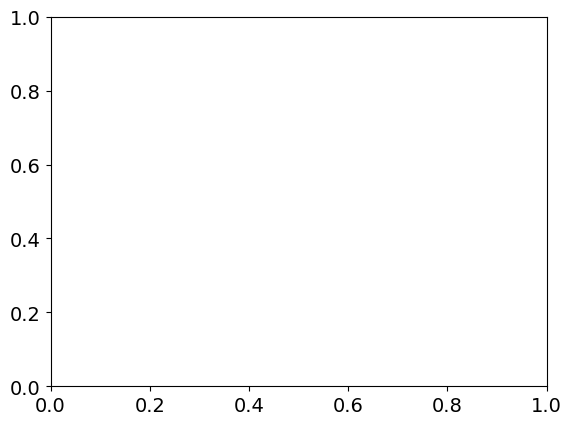

In [11]:
labels="noise:{:F} \n perturbation:{:F}".format(noise_strength,perturbation_strength)

print(chao)
font = {
        'size'   : 14}
plt.rc('font', **font)

intervals=50
x=np.arange(1,epochs/intervals+2)
xx=np.arange(1,epochs/intervals+1)
print(len(x))
print(len(chao))
plt.scatter(x,y=chao,label=labels)
plt.ylabel("fraction of images in chaos")
plt.xlabel("epoch/"+str(interval))
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig("percentage of image in chaos.jpg")

np.savetxt("percentage of chaos.txt",chao)
plt.show()







print("asymptotic distance")

plt.scatter(x,y=asymptotic_dist,label=labels)
#labels="noise:"+str(noise_strength)+", perturbation:"+str(perturbation_strength)
plt.ylabel("asymptotic distance")
plt.xlabel("epoch/"+str(interval))
plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig("asymptotic distance.jpg",)

plt.show()
np.savetxt("asymptotic distance.txt",asymptotic_dist)
average_jacobian=np.asarray(average_jacobian)

#print("average jacobian")
#plt.scatter(x,y=average_jacobian,label="noise:{:F}\n perturbation:{:F}".format(noise_strength,perturbation_strength))
#plt.ylabel("average jacobian")
#plt.xlabel("epoch/"+str(interval))
#plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
#plt.legend(loc="best")
#plt.savefig("average_jacobian.jpg")
#np.savetxt("average jacobian.txt",average_jacobian)
#plt.show()

#print("spectral radius")
#plt.scatter(x,y=spectral_radiuses,label="noise:{:F},perturbation:{:F}".format(noise_strength,perturbation_strength))
#plt.ylabel("spectral radius")
#plt.xlabel("epoch/20")
#plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
#plt.legend(loc="best")
#plt.savefig("spectral radius.jpg")

np.savetxt("spectral radius.txt",spectral_radiuses)
plt.show()

print("loss function")
plt.plot(validation_loss,label="validation loss")
plt.plot(training_loss,label="training loss")
plt.ylabel("losss")
plt.xlabel("epoch")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.yscale("log")
plt.savefig("loss function.jpg")
plt.show()
#print("asymptotic distance")
plot_loss=[]
for i in range(len(validation_loss)):
    if i%intervals==0:
        plot_loss.append(validation_loss[i])
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epoch/'+str(intervals))
ax1.set_ylabel('validation loss', color=color)
ax1.scatter(xx,y=plot_loss, label="validation loss",color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_yscale("log")
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('asymptotic distance', color=color)  # we already handled the x-label with ax1
ax2.scatter(x,y=asymptotic_dist, color=color,label="asymptotic distance")
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale("log")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
plt.scatter(xx,plot_loss,label="validation loss")
        
        
        
#plt.plot(x,plot_loss,label="validation loss")
plt.scatter(xx,y=asymptotic_dist[1:],label="asymptotic distance")

#labels="noise:"+str(noise_strength)+", perturbation:"+str(perturbation_strength)
plt.ylabel("asymptotic distance")
plt.xlabel("epoch/"+str(interval))
plt.yscale("log")
#plt.set_label("noise:{:.f},perturbation:{:.f}".format(noise_strength,perturbation_strength))
plt.legend(loc="best")
plt.savefig("asymptotic distance.jpg")

plt.show()
np.savetxt("loss_function.txt",(validation_loss,training_loss))
plt.show()

plt.plot(validation_loss)
plt.yscale("log")
plt.show()
plt.plot(training_loss)
plt.yscale("log")
plt.show()